<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/CombiningGroups_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Last changed 11/11 13:09
Reminder to self, please save over AllRuns.ipynb in github/rr/cifar10/collectionoftests

Description:  batches are mixing well, but horrible accuracy for certain images, maybe thats a "good" test result?  About to pass all the groups through the augmentation, maybe 1 hour * 10 groups?  

Still need to do the CSV output

### Imports

In [1]:
 # I don't want to accidentally restart my notebook so I have a break here. 
# I'm only working from the last part of the notebook where I import the results


#@title import libraries set time
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!
import random
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time
import pickle
from google.colab import files
import datetime # to display the current time hh:mm:ss



tic = time.time()  # Start the timer
initial_run = 0

AUTOTUNE = tf.data.experimental.AUTOTUNE
np.set_printoptions(precision=4)

#### Set Random Seeds

In [2]:
#@title
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed()  # https://stackoverflow.com/questions/11526975/set-random-seed-programwide-in-python
shuffle_seed = seed

# Possibly Need IMGAUG to set seed in ALbumentations
# GitHub Issue: https://github.com/albumentations-team/albumentations/issues/93
import imgaug
imgaug.seed(123)


## ------------------

Set Logic-Values


In [3]:
run_model = False  #When Im looking at augmentations, I don't want to keep refitting a model, I want to just get the database of images loaded

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  

The second biggest was using the created model to make predictions on the test set.   

Current but "skipped" problem is trying to view misclassifeid images of results.


Another area of problems is rerunning when you've already specified a batch on your dataset creates another "batch" split so it can cause problems to rerun a cell that says how to define a dataset.  Unbatch may be needed first.    

# **1. Create All DataSets**

### Load Dataset

In [4]:
#@title


# A weird problem happened where it said the toronto website cant be reached, if that ever happens again make sure to go to SO for this advice https://stackoverflow.com/questions/36805640/this-error-while-downloading-datasets-valueerror-i-o-operation-on-closed-file

# How do I set IDs on: read_config.add_tfds_id = True
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True  ## This didnt update ReadConfig 

dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
x_test =  dataset["test"]
dataset  = dataset["train"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


#  I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels
y_test = get_labels_from_tfdataset(x_test)

# tfds.as_dataframe(dataset.take(5), info)  #does not display image ID :-( )

dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("There are ways to count and verify the number per training set which i have hidden because they are costly")
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
# for img, label in dataset_dogs:
#   assert label == 5
 

There are ways to count and verify the number per training set which i have hidden because they are costly
Entire Training Dataset was originally cardinality: 50000
Entire Airplane Training Dataset was originally cardinality: -2


### Show Examples in the Three Train/Val/Test Sets.  Count CIFAR 10 Functions

In [5]:
#@title 'count_cifar10_class' { form-width: "1px" }
# define a fuction to count the numbre of each class
# I'm not going to worry about it now, but if i had time to cleanup code I would 
# Try to use this type of if/zip structure  https://stackoverflow.com/questions/57784643/if-statement-and-zip



 
def count_cifar10_class(datasetpassed):
  # takes the datasetpassed and returns the number of each category as a ten-tupple
  num_airplanes, num_automobiles, num_birds, num_cats, num_deers = 0,0,0,0,0
  num_dogs, num_frogs, num_horses, num_ships, num_trucks= 0, 0, 0,0,0


  # print("Unbatched?" , check_if_unbatched(datasetpassed))
  # print("Take?", check_if_take(datasetpassed))
  # print("Unbatched or Take?", ( check_if_unbatched(datasetpassed) or  check_if_take(datasetpassed)))

  if ( check_if_unbatched(datasetpassed) or  check_if_take(datasetpassed)):
    if check_if_take(datasetpassed):
      datasetpassed = make_unbatched(datasetpassed)

    for img, label in datasetpassed:
      if label == 0:
        num_airplanes += 1

      if label == 1:
        num_automobiles += 1

      if label == 2:
        num_birds +=1

      if label == 3:
        num_cats +=1

      if label ==4: 
        num_deers += 1

      if label == 5:
        num_dogs += 1 

      if label == 6:
          num_frogs += 1

      if label == 7:
        num_horses += 1

      if label == 8:
        num_ships +=1 

      if label == 9: 
        num_trucks +=1
    
    return num_airplanes, num_automobiles, num_birds, num_cats, num_deers, num_dogs, num_frogs, num_horses, num_ships, num_trucks 
  # else if the dataset is not batched or if one batch from take is being passed, proceed to counting thing below 
  else:
    print(" ** Dataset is batched, please pass 1 batch at a time to cifar10 to see metrics ** ")



  




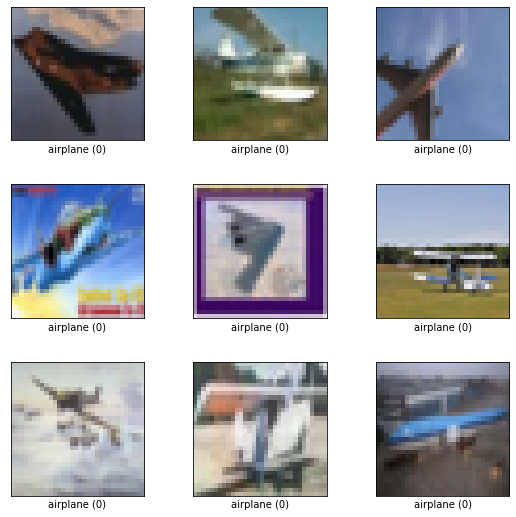

In [6]:
#@title ShowExamplesofDatasetAirplanes
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

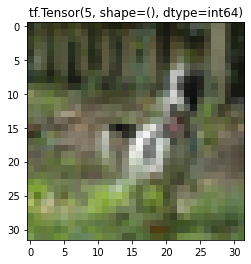

In [7]:
#@title ShowExampleofOneIterations of DatasetDogs { form-width: "20px" }
# I wish I could display ID!!

img, label = next(iter(dataset_dogs))
plt.title(str(label))
plt.imshow(img)

#0x7f6e309eff10?


## Create validation set of 10,000 images

In [8]:
#@title
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
  
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



## Create smaller training groups of each CIFAR Class sets (set Shard)

After removing the 10,000 validation set from the training-data, the remaining set has 40,000 images, 4000 images of each class.  To create smaller training-datasets of similar sizes, shard the dataset into equal pieces.

For the initial days of testing I decided on **250 images** per class for my first couple runs, which equates to 16 shards (40,000/16 = 250) .  When I wanted to study what was going on more beneath the hood for my augmentations, I decided to make the training set even more tiny so I could view all the images per training set I decided to try 1 image per class so I could easily view all the images augmeted and not augmented.  This meant I needed **4000 shards!** for troubleshooting.



In [9]:
SHARDS=16

 Airplanes (airplanes_A, ... airplanes_P)

In [10]:
#@title
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=SHARDS, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=SHARDS, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=SHARDS, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=SHARDS, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=SHARDS, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=SHARDS, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=SHARDS, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=SHARDS, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=SHARDS, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=SHARDS, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=SHARDS, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=SHARDS, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=SHARDS, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=SHARDS, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=SHARDS, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


 Automobiles

In [11]:
#@title
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=SHARDS, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=SHARDS, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=SHARDS, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=SHARDS, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=SHARDS, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=SHARDS, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=SHARDS, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=SHARDS, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=SHARDS, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=SHARDS, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=SHARDS, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=SHARDS, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=SHARDS, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=SHARDS, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=SHARDS, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

 Birds

In [12]:
#@title
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=SHARDS, index = 0)
birds_B = dataset_birds.shard(num_shards=SHARDS, index = 1)
birds_C = dataset_birds.shard(num_shards=SHARDS, index = 2)
birds_D = dataset_birds.shard(num_shards=SHARDS, index = 3)
birds_E = dataset_birds.shard(num_shards=SHARDS, index = 4)
birds_F = dataset_birds.shard(num_shards=SHARDS, index = 5)
birds_G = dataset_birds.shard(num_shards=SHARDS, index = 6)
birds_H = dataset_birds.shard(num_shards=SHARDS, index = 7)
birds_I = dataset_birds.shard(num_shards=SHARDS, index = 8)
birds_J = dataset_birds.shard(num_shards=SHARDS, index = 9)
birds_K = dataset_birds.shard(num_shards=SHARDS, index = 10)
birds_L = dataset_birds.shard(num_shards=SHARDS, index = 11)
birds_M = dataset_birds.shard(num_shards=SHARDS, index = 12)
birds_N = dataset_birds.shard(num_shards=SHARDS, index = 13)
birds_O = dataset_birds.shard(num_shards=SHARDS, index = 14)
birds_P = dataset_birds.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

 Cats

In [13]:
#@title
# dataset_cats

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=SHARDS, index = 0)
cats_B = dataset_cats.shard(num_shards=SHARDS, index = 1)
cats_C = dataset_cats.shard(num_shards=SHARDS, index = 2)
cats_D = dataset_cats.shard(num_shards=SHARDS, index = 3)
cats_E = dataset_cats.shard(num_shards=SHARDS, index = 4)
cats_F = dataset_cats.shard(num_shards=SHARDS, index = 5)
cats_G = dataset_cats.shard(num_shards=SHARDS, index = 6)
cats_H = dataset_cats.shard(num_shards=SHARDS, index = 7)
cats_I = dataset_cats.shard(num_shards=SHARDS, index = 8)
cats_J = dataset_cats.shard(num_shards=SHARDS, index = 9)
cats_K = dataset_cats.shard(num_shards=SHARDS, index = 10)
cats_L = dataset_cats.shard(num_shards=SHARDS, index = 11)
cats_M = dataset_cats.shard(num_shards=SHARDS, index = 12)
cats_N = dataset_cats.shard(num_shards=SHARDS, index = 13)
cats_O = dataset_cats.shard(num_shards=SHARDS, index = 14)
cats_P = dataset_cats.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

 Deer(s)

In [14]:
#@title
# dataset_deers
# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=SHARDS, index = 0)
deers_B = dataset_deers.shard(num_shards=SHARDS, index = 1)
deers_C = dataset_deers.shard(num_shards=SHARDS, index = 2)
deers_D = dataset_deers.shard(num_shards=SHARDS, index = 3)
deers_E = dataset_deers.shard(num_shards=SHARDS, index = 4)
deers_F = dataset_deers.shard(num_shards=SHARDS, index = 5)
deers_G = dataset_deers.shard(num_shards=SHARDS, index = 6)
deers_H = dataset_deers.shard(num_shards=SHARDS, index = 7)
deers_I = dataset_deers.shard(num_shards=SHARDS, index = 8)
deers_J = dataset_deers.shard(num_shards=SHARDS, index = 9)
deers_K = dataset_deers.shard(num_shards=SHARDS, index = 10)
deers_L = dataset_deers.shard(num_shards=SHARDS, index = 11)
deers_M = dataset_deers.shard(num_shards=SHARDS, index = 12)
deers_N = dataset_deers.shard(num_shards=SHARDS, index = 13)
deers_O = dataset_deers.shard(num_shards=SHARDS, index = 14)
deers_P = dataset_deers.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

 Dogs

In [15]:
#@title
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=SHARDS, index = 0)
dogs_B = dataset_dogs.shard(num_shards=SHARDS, index = 1)
dogs_C = dataset_dogs.shard(num_shards=SHARDS, index = 2)
dogs_D = dataset_dogs.shard(num_shards=SHARDS, index = 3)
dogs_E = dataset_dogs.shard(num_shards=SHARDS, index = 4)
dogs_F = dataset_dogs.shard(num_shards=SHARDS, index = 5)
dogs_G = dataset_dogs.shard(num_shards=SHARDS, index = 6)
dogs_H = dataset_dogs.shard(num_shards=SHARDS, index = 7)
dogs_I = dataset_dogs.shard(num_shards=SHARDS, index = 8)
dogs_J = dataset_dogs.shard(num_shards=SHARDS, index = 9)
dogs_K = dataset_dogs.shard(num_shards=SHARDS, index = 10)
dogs_L = dataset_dogs.shard(num_shards=SHARDS, index = 11)
dogs_M = dataset_dogs.shard(num_shards=SHARDS, index = 12)
dogs_N = dataset_dogs.shard(num_shards=SHARDS, index = 13)
dogs_O = dataset_dogs.shard(num_shards=SHARDS, index = 14)
dogs_P = dataset_dogs.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


 Frogs

In [16]:
#@title
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=SHARDS, index = 0)
frogs_B = dataset_frogs.shard(num_shards=SHARDS, index = 1)
frogs_C = dataset_frogs.shard(num_shards=SHARDS, index = 2)
frogs_D = dataset_frogs.shard(num_shards=SHARDS, index = 3)
frogs_E = dataset_frogs.shard(num_shards=SHARDS, index = 4)
frogs_F = dataset_frogs.shard(num_shards=SHARDS, index = 5)
frogs_G = dataset_frogs.shard(num_shards=SHARDS, index = 6)
frogs_H = dataset_frogs.shard(num_shards=SHARDS, index = 7)
frogs_I = dataset_frogs.shard(num_shards=SHARDS, index = 8)
frogs_J = dataset_frogs.shard(num_shards=SHARDS, index = 9)
frogs_K = dataset_frogs.shard(num_shards=SHARDS, index = 10)
frogs_L = dataset_frogs.shard(num_shards=SHARDS, index = 11)
frogs_M = dataset_frogs.shard(num_shards=SHARDS, index = 12)
frogs_N = dataset_frogs.shard(num_shards=SHARDS, index = 13)
frogs_O = dataset_frogs.shard(num_shards=SHARDS, index = 14)
frogs_P = dataset_frogs.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

 Horses

In [17]:
#@title
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=SHARDS, index = 0)
horses_B = dataset_horses.shard(num_shards=SHARDS, index = 1)
horses_C = dataset_horses.shard(num_shards=SHARDS, index = 2)
horses_D = dataset_horses.shard(num_shards=SHARDS, index = 3)
horses_E = dataset_horses.shard(num_shards=SHARDS, index = 4)
horses_F = dataset_horses.shard(num_shards=SHARDS, index = 5)
horses_G = dataset_horses.shard(num_shards=SHARDS, index = 6)
horses_H = dataset_horses.shard(num_shards=SHARDS, index = 7)
horses_I = dataset_horses.shard(num_shards=SHARDS, index = 8)
horses_J = dataset_horses.shard(num_shards=SHARDS, index = 9)
horses_K = dataset_horses.shard(num_shards=SHARDS, index = 10)
horses_L = dataset_horses.shard(num_shards=SHARDS, index = 11)
horses_M = dataset_horses.shard(num_shards=SHARDS, index = 12)
horses_N = dataset_horses.shard(num_shards=SHARDS, index = 13)
horses_O = dataset_horses.shard(num_shards=SHARDS, index = 14)
horses_P = dataset_horses.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

 Ships

In [18]:
#@title
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=SHARDS, index = 0)
ships_B = dataset_ships.shard(num_shards=SHARDS, index = 1)
ships_C = dataset_ships.shard(num_shards=SHARDS, index = 2)
ships_D = dataset_ships.shard(num_shards=SHARDS, index = 3)
ships_E = dataset_ships.shard(num_shards=SHARDS, index = 4)
ships_F = dataset_ships.shard(num_shards=SHARDS, index = 5)
ships_G = dataset_ships.shard(num_shards=SHARDS, index = 6)
ships_H = dataset_ships.shard(num_shards=SHARDS, index = 7)
ships_I = dataset_ships.shard(num_shards=SHARDS, index = 8)
ships_J = dataset_ships.shard(num_shards=SHARDS, index = 9)
ships_K = dataset_ships.shard(num_shards=SHARDS, index = 10)
ships_L = dataset_ships.shard(num_shards=SHARDS, index = 11)
ships_M = dataset_ships.shard(num_shards=SHARDS, index = 12)
ships_N = dataset_ships.shard(num_shards=SHARDS, index = 13)
ships_O = dataset_ships.shard(num_shards=SHARDS, index = 14)
ships_P = dataset_ships.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

 Trucks


In [19]:
#@title
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=SHARDS, index = 0)
trucks_B = dataset_trucks.shard(num_shards=SHARDS, index = 1)
trucks_C = dataset_trucks.shard(num_shards=SHARDS, index = 2)
trucks_D = dataset_trucks.shard(num_shards=SHARDS, index = 3)
trucks_E = dataset_trucks.shard(num_shards=SHARDS, index = 4)
trucks_F = dataset_trucks.shard(num_shards=SHARDS, index = 5)
trucks_G = dataset_trucks.shard(num_shards=SHARDS, index = 6)
trucks_H = dataset_trucks.shard(num_shards=SHARDS, index = 7)
trucks_I = dataset_trucks.shard(num_shards=SHARDS, index = 8)
trucks_J = dataset_trucks.shard(num_shards=SHARDS, index = 9)
trucks_K = dataset_trucks.shard(num_shards=SHARDS, index = 10)
trucks_L = dataset_trucks.shard(num_shards=SHARDS, index = 11)
trucks_M = dataset_trucks.shard(num_shards=SHARDS, index = 12)
trucks_N = dataset_trucks.shard(num_shards=SHARDS, index = 13)
trucks_O = dataset_trucks.shard(num_shards=SHARDS, index = 14)
trucks_P = dataset_trucks.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


### New Groups: A (trainA)
I discovered a better way to zip, batch, my training sets.


#### Admin functions

In [20]:
#@title
# #@title admin fxs to print out code  / future users wont need to rerun
# # here i create text that i can copy and paste into code-cells
# from itertools import cycle
# #https://stackoverflow.com/questions/19686533/how-to-zip-two-differently-sized-lists

# letter="A"
# def printoutlistofsubsets(letter):
#   listofobjects  = ("airplanes_", "automobiles_", "birds_", "cats_", "deers_", 
#                     "dogs_", "frogs_", "horses_", "ships_", "trucks_")
#   print("train", letter, "_subsets = ("   ,sep="" , end = "")
#   counter=0
#   for i in listofobjects:
#     counter+=1
#     if counter<10:
#       print( i,letter, ", " ,sep="", end="")
#     else:
#       print(i,letter , sep="", end=" ")
#   print(")"    )

# for i in list(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]):
#   printoutlistofsubsets(i) #I  manually copy/paste the output to run as future code

Define Zip Function

it's defined as zip_9 below need to move it up here

In [21]:
 #@title def zip_9_sets()
def zip_9_sets(tuple_of_9_subsets_to_zip, opttext="9 Sets Zipped and Concatenated"):
  combined = tf.data.Dataset.zip((tuple_of_9_subsets_to_zip)).flat_map(
    lambda x0, x1, x2, x3, x4, x5,x6,x7,x8,x9:
     tf.data.Dataset.from_tensors(x0).concatenate(
        tf.data.Dataset.from_tensors(x1).concatenate(
            tf.data.Dataset.from_tensors(x2).concatenate(
                tf.data.Dataset.from_tensors(x3).concatenate(
                     tf.data.Dataset.from_tensors(x4).concatenate(
                          tf.data.Dataset.from_tensors(x5).concatenate(
                               tf.data.Dataset.from_tensors(x6).concatenate(
                                    tf.data.Dataset.from_tensors(x7).concatenate(
                                         tf.data.Dataset.from_tensors(x8).concatenate(
                                              tf.data.Dataset.from_tensors(x9))
                               )
                          )
                     )
                )
            )
          )
      )
    ))
  print(opttext)
  return combined



Define Zip2 Sets so I can Zip Together Alb+ No_Alb

In [22]:
#@title def zip_2_sets()
def zip_2_sets(tuple_of_2_subsets_to_zip, opttext="Two Sets Zipped and Concatenated"):
  combined = tf.data.Dataset.zip((tuple_of_2_subsets_to_zip)).flat_map(
    lambda x0, x1:
     tf.data.Dataset.from_tensors(x0).concatenate(
        tf.data.Dataset.from_tensors(x1)))
  
  print(opttext)
  return combined

In [23]:
# #@title admin fxs to print out code2  / future users wont need to rerun
# def printoutzip9sets(letter):
#   print("train", letter, " = zip_9_sets(train", letter, "_subsets,", " opttext= \"train", letter, " defined \" )",sep="" )
   
# for i in list(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]):
#   printoutzip9sets(i) #I  manually copy/paste the output to run as future code



### Create subset tuples

In [24]:
trainA_subsets = (airplanes_A, automobiles_A, birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A )
trainB_subsets = (airplanes_B, automobiles_B, birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B )
trainC_subsets = (airplanes_C, automobiles_C, birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C )
trainD_subsets = (airplanes_D, automobiles_D, birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D )
trainE_subsets = (airplanes_E, automobiles_E, birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E )
trainF_subsets = (airplanes_F, automobiles_F, birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F )
trainG_subsets = (airplanes_G, automobiles_G, birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G )
trainH_subsets = (airplanes_H, automobiles_H, birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H )
trainI_subsets = (airplanes_I, automobiles_I, birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I )
trainJ_subsets = (airplanes_J, automobiles_J, birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J )

## Create Training Sets A through J, and AB, CD, EF, GH, ABCD, EFGH, ABCDEFGH

In [25]:
trainA = zip_9_sets(trainA_subsets, opttext= "trainA defined " )
trainB = zip_9_sets(trainB_subsets, opttext= "trainB defined " )
trainC = zip_9_sets(trainC_subsets, opttext= "trainC defined " )
trainD = zip_9_sets(trainD_subsets, opttext= "trainD defined " )
trainE = zip_9_sets(trainE_subsets, opttext= "trainE defined " )
trainF = zip_9_sets(trainF_subsets, opttext= "trainF defined " )
trainG = zip_9_sets(trainG_subsets, opttext= "trainG defined " )
trainH = zip_9_sets(trainH_subsets, opttext= "trainH defined " )
# trainI = zip_9_sets(trainI_subsets, opttext= "trainI defined " )
# trainJ = zip_9_sets(trainJ_subsets, opttext= "trainJ defined " )

#I decided I don' want to zip,  I rather concatenate, otherwise I'm going to be seeing the same image over and over again... plus its faster

trainAB = trainA.concatenate(trainB)
trainCD = trainC.concatenate(trainD)
trainEF = trainE.concatenate(trainF)
trainGH = trainG.concatenate(trainH)

# trainCD = zip_2_sets((trainC, trainD), opttext="trainCD defined")
# trainEF = zip_2_sets((trainE, trainF), opttext="trainEF defined")
# trainGH = zip_2_sets((trainG, trainH), opttext="trainGH defined")
# # trainIJ = zip_2_sets((trainI, trainJ), opttext="trainIJ defined")

trainABCD = trainAB.concatenate(trainCD)
trainEFGH = trainEF.concatenate(trainGH)

# trainABCD = zip_2_sets((trainAB, trainCD), opttext="trainABCD defined")
# trainEFGH = zip_2_sets((trainEF, trainGH), opttext="trainEFGH defined")

trainABCDEFGH = trainABCD.concatenate(trainEFGH)
# trainABCDEFGH = zip_2_sets((trainABCD, trainEFGH), opttext="trainABCDEFGH defined")



# trainAB = zip_2_sets((trainA, trainB), opttext="trainAB defined")
# trainCD = zip_2_sets((trainC, trainD), opttext="trainCD defined")
# trainEF = zip_2_sets((trainE, trainF), opttext="trainEF defined")
# trainGH = zip_2_sets((trainG, trainH), opttext="trainGH defined")
# # trainIJ = zip_2_sets((trainI, trainJ), opttext="trainIJ defined")

# trainABCD = zip_2_sets((trainAB, trainCD), opttext="trainABCD defined")
# trainEFGH = zip_2_sets((trainEF, trainGH), opttext="trainEFGH defined")

# trainABCDEFGH = zip_2_sets((trainABCD, trainEFGH), opttext="trainABCDEFGH defined")

trainA defined 
trainB defined 
trainC defined 
trainD defined 
trainE defined 
trainF defined 
trainG defined 
trainH defined 


Testing out whether I can see IDs again...

I added some code before the lines to load dataset, they are as follows#
from https://www.tensorflow.org/datasets/api_docs/python/tfds/load#args
and https://www.tensorflow.org/datasets/determinism



> read_config code added


```
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
```


I want to make sure the rest of my scripts run fine before any more tinkering!

In [26]:
# # I believe I need to define the shuffle number for the Train_A set by using the total number of images in it, not just an arbitrarily large number?
# # count = count_images(trainA)
# # unbatch_trainA = (tf.data.Dataset.unbatch(trainA))
# # count = count_images(unbatch_trainA)

# #this changes everytime i run it

# # for id, img, label in unbatch_trainA:
# #   print(label)  # this appears to be the labels of the image in unbatchtrainA (7, 6, 4, 2, 1, 3, 9, 5, 8, 0)
# #   #print(img)  # these are each of the images 32*32*3
# #   print(id)
 
# tfds.as_dataframe(dataset.take(5), info)  #it doesn't look like IDS is being returned in info

# print(info)


The result of running `print(info)`:

> CIFAR10 Info
```
tfds.core.DatasetInfo(    
    name='cifar10',
    version=3.0.2,    
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',   
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',   
    features=FeaturesDict({   
        'id': Text(shape=(), dtype=tf.string),   
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),   
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),   
    }),   
    total_num_examples=60000,   
    splits={   
        'test': 10000,   
        'train': 50000,   
    },   
    supervised_keys=('image', 'label'),   
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,   
        author = {Alex Krizhevsky},   
        title = {Learning multiple layers of features from tiny images},   
        institution = {},  
        year = {2009}   
    }""",   
    redistribution_info=,   
)
```
 




## Define dataset functions to make (view_image(ds) function work

In [27]:
#@title define CLASSES
# The augmented data returns floats between 0 and 1
# The unaugmented data is integers uint8 between 0 and 255 
CLASSES = info.features['label'].names

# This may help mm one day with trying to get into the ID of each batch/mislabelled image
# info.features['id']


In [28]:
#@title def check_if_unbatched(ds): { form-width: "20px" }
def check_if_unbatched(ds):
  if (ds.__class__.__name__ !='BatchDataset') and (ds._input_dataset.__class__.__name__ != 'BatchDataset') :
     return True
  else:
    return False

In [29]:
#@title def check_if_batched(ds): { form-width: "20px" }
def check_if_batched(ds):
  if (ds.__class__.__name__ =='BatchDataset') or (ds._input_dataset.__class__.__name__ == 'BatchDataset')  :
     # the above statement will evaluate to True if three subsets of the original ds are not batched
      return True
  else:
    return False

In [30]:
#@title def check_if_take(ds): { form-width: "20px" }

def check_if_take(ds):
  if  (ds.__class__.__name__ =='TakeDataset'):
    return True
  else:
    return False

In [31]:
#@title def inprogress check_if_zipped(ds): { form-width: "20px" }

def check_if_zipped(ds):
  if  (ds.__class__.__name__ =='ZippedDataset'):
    return True
  else:
    return False
 

In [32]:
#@title def make_batched(ds, batchnum): { form-width: "20px" }

def make_batched(ds, batchnum):
  if check_if_unbatched(ds):
    # the above statement will evaluate to True if three subsets of the original ds are not batched
    return ds.batch(batchnum)
  else:
    return ds

In [33]:
#@title def unbatch_ds(batchedDataset): { form-width: "20px" }

def unbatch_ds(batchedDataset):
  unbatch_ds = (tf.data.Dataset.unbatch(batchedDataset))
  return unbatch_ds



In [34]:
#@title def make_unbatched(ds): { form-width: "20px" }
def make_unbatched(ds):
  if  check_if_batched(ds):
      # the above statement will evaluate to True if any of the three subsets are batched
      return unbatch_ds(ds)
  else:
    return ds

In [35]:
#@title def make_zipped_batched(ds, batchnum): { form-width: "20px" }
def make_zipped_batched(ds, batchnum):
  return ds.batch(batchnum)

In [36]:
#@title def count_images(ds, opttext)
def count_images(ds, opttext = ""):
  # The number of images present in the new trainA_alb set is equal to the original set
  num_images = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 10 bc no batches
  print(" There are ** ", num_images, "** total images in " ,  opttext)
  return num_images

## Define view_image functions

In [37]:
#@title def view_image(ds, opttext = ""):

def view_image(ds, opttext = ""):
# this function takes the dataset and automatically displays 10 figures
# the dataset has to be batched to see the images
  
    temp_ds  = make_batched(ds, 10)


    image, label = next(iter(temp_ds)) # extract 1 batch from the dataset
    image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
    label = label.numpy()   
    

    fig = plt.figure(figsize=(16, 16))
    for i in range(10):
      if i == 1:
          print("*"*20, " "*10, opttext, " "*10,  "*"*20)
      ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"Label: {label[i]}")
      if i == 9:
        plt.pause(0.05)  # heck yea

  


# view_image(val, opttext = "First 10 Validation Images")
# view_image(x_test, opttext = "First 10 Test Images")
# view_image(trainA, opttext = "First 10 Training Images from Group A / not yet batched or mixed")


To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

#1 Pretty

In [38]:
#@title def pretty_display_of_dataset(ds, dstitle = "Dataset title", opttext = ""):  { form-width: "20px" }
 
def pretty_display_of_dataset(ds, dstitle = "Dataset title", opttext = "", troubleshooting=False):
  """ pretty_display_of_dataset counts number of entries,  displays first 10 images or first 5 batches 
  also counts the number of each class in each batch """
  if not(troubleshooting):
    num = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 25, but 25*100batches = 2500
    print("num:", num)  

    # view_image(ds, "Whole dataset first 10 images (not batched)") 

    # print("Total: ", num, " images in this dataset", opttext )
    # print("Total Class Count:", count_cifar10_class(ds), "\n")

    if check_if_batched(ds):
      print("Total: ", num, " batches in this dataset:", dstitle )

      if num > 5:
        num = 5
        print("Showing first 10 images of the first five batches of ", dstitle)
      
      batch1 = ds.take(1)
       
      view_image(batch1, str("Batch1 of "+dstitle)) 
      print("Batch ",1, "Class Count:", count_cifar10_class(batch1), "\n")  

      for i in range(2,num+1):      
        batch2 = ds.skip(i-1).take(1)
      
        name_of_batch = str("Batch" + str(i) +" of "+ dstitle)
        view_image(batch2, name_of_batch )


        print("Batch ", i, "Class Count:", count_cifar10_class(batch2), "\n")
        # do I need to clear out batch2 here?
    if check_if_unbatched(ds):
      ds_batch = make_batched(ds, 10)
      batch1 = ds_batch.take(1)
      view_image(batch1, str("First 10 pics of unbatched "+dstitle)) 
      batch2 = ds_batch.skip(10).take(1)
      view_image(batch2, str("Skip 10 batches/images, Showing next 10 pics of unbatched "+dstitle)) 


    print("**********************************************************************************************")

  else:
    num = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 25, but 25*100batches = 2500
    print("num:", num)  
    # batch1 = ds.take(1)
    # view_image(batch1, str("Batch1 of "+dstitle)) 
    # print("Batch ",1, "Class Count:", count_cifar10_class(batch1), "\n")
    view_40_images(make_unbatched(ds))


 

In [39]:
#@title def view_40_images(ds, num = 40): { form-width: "20px" }
# I don't know why the images looks so small 

def view_40_images(ds, num = 40):

  temp_ds = make_zipped_batched(ds, batchnum = num)

  # temp_ds = make_batched(ds, batchnum = num)

  image, label = next(iter(temp_ds)) # extract 1 batch from the dataset
  image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
  label = label.numpy()   
  
  fig =  plt.figure(figsize=(100, 100))
  fig2 = plt.figure(figsize=(100, 100))

  #if i want to display 40 pictures in 4 rows 10 columns i need a subplot(2,10,i)

 

  for i in range(num):
    if i <= 19:
      ax = fig.add_subplot(1, num, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"{CLASSES[label[i]][0:4]}")
    if i > 19 :
      new_i = i-10
      ax = fig2.add_subplot(1, num, new_i+1, xticks=[], yticks=[])
      # fig2.tight_layout()
      ax.imshow(image[i])
      ax.set_title(f"{CLASSES[label[i]][0:4]}")


# view_40_images(trainB, )

## Prepare the Google Colab environment for Albumentations



#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [40]:
#@title  instal augmentations
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

!pip install -U git+https://github.com/albumentations-team/albumentations -q
# necessary imports
from functools import partial
import albumentations as A
import cv2 as cv2

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE


## Define Augmentation Factors' Order and Levels

The following are 21 factors: 20 data-augmentation techniques and one regularization factor "*Dropout*" Percent Level, to compare with.  The order is what seemed to give each factor the most opportunity to add to the image, and more "destructive" factors were ordered later, like "ToGray" and Crop or ZoomIn since they take away image data permanently.  Zoom Out was order 11 because I wanted to make sure noise, blur, zoom, sharpen, contrast, did not have a over-magnified effect if after ZoomOut.  FlipHorizontal and FlipVertical are at the bottom not because they are destructive, but because I wanted to keep the categorical variables grouped as much as possible for consistent coding practices.

|Order | Factors | Role | Low | High |
| -: | :- | :-: | :-: | :-: |
1|*dropout*|Continuous|0.4  |0.6
2|shiftX|Continuous|0 | 0.1
3|shiftY|Continuous|0|  0.1
4|noise|Continuous|0  |24
5|blur|Continuous|0 | 7**
6|sharpen|Continuous|0 | 0.1
7|contrast|Continuous|0 | 0.2
8|brighten|Continuous|0|  0.2
9|darken (negative brightness)|Continuous|0 | -0.2 *
10|gamma|Continuous|100|  120
11|zoomOut (negative zoomin) |Continuous| 0 | -0.16*
12|rotate|Continuous|0|  14
13|crop|Continuous|32* | 24*
14|zoomin|Continuous|0  |0.16
15|flipH|Categorical|0 | 1
16|flipV|Categorical|0 | 1
17|fancyPCA|Categorical|0 | 1
18|equalize|Categorical|0 | 1
19|channelShuffle|Categorical|0 | 1
20|elasticTransform|Categorical|0 | 1
21|togray|Categorical|0 | 1

* Values with asterisks are for emphasis since they seem counterintuitive

** Blur values can only be odd so a center point will be rounded down from 3.5 to 3 - four center points were changed

A 50-run definitive screening design with 2 blocks is used to see which main effects are most important.  The JMP Metrics for this design are below:

 | Definitive Screening Design Diagnostics  | | 
| --- | --- | 
 | D Efficiency| 92.46019| 
| G Efficiency | 81.68744 | 
| A Efficiency | 91.32396 | 
| Average Variance of Prediction	 | 0.298038 |


##  Batches, Buffers, Shuffles and Caches to Val, and Test, but not TrainX yet

The following is necessary to run the datasets through the CNN models  Do not run the following more than once because it'll try to make an additional "batch" dimension in your datasets

In [41]:

if initial_run == 0: 
    
  # AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
  # trainA = trainA.cache().prefetch(buffer_size=AUTOTUNE)
  # trainA = trainA.shuffle(trainA_shuffle_num, reshuffle_each_iteration=False)  #, seed=seed)
  # trainA = trainA.batch(tran_A_batch_num)  
  val = val.batch(10)
  val = val.shuffle(10000)  #shuffle one time
  val = unbatch_ds(val)
  val = val.cache().prefetch(buffer_size=AUTOTUNE)
  val = val.batch(500)

  x_test = x_test.cache().prefetch(AUTOTUNE)
  x_test = x_test.batch(500)

else:
  pass

initial_run = initial_run+1

In [42]:
# look at some pictures
 

## Time required to create datasets:  294 seconds

it used to take 23 seconds, i guess zipping is more computationally expensive then concatenating

In [43]:
#@title

toc = time.time()  
print(f"Made datasets in {toc - tic:0.4f} seconds")
!mkdir -p saved_model


Made datasets in 15.2731 seconds


#  **2. Build Vanilla CNN**

## Define the makemodel and trainmodel functions   

 




In [44]:
#@title def makemodel(DROPOUT):{ form-width: "20px" }
# Make a Vanilla CNN
# One thing I'd like to add is residual connections, as Cholet mentions that is a standard practice in computer vision


def makemodel(DROPOUT):  #returns model
  num_classes = 10
  input_shape = (32, 32, 3)

  # For Reference these are the defaults
  # kernel_initializer="glorot_uniform",
  # bias_initializer="zeros",
  # padding="valid",  #valid = no padding
  # kernel_regularizer=None,
  # bias_regularizer=None,
  # activity_regularizer=None,

  initializer = tf.keras.initializers.HeUniform(seed)  #this alows the model to start from the same weights each time

  model = tf.keras.Sequential(
  [
      #keras.Input(),
      tf.keras.Input(shape=input_shape),

      layers.experimental.preprocessing.Rescaling(1./255),
      #data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
      layers.BatchNormalization(name="BN1"),
   
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
      layers.BatchNormalization(name="BN2"),
   
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
      layers.BatchNormalization(name="BN3"),
   
      layers.Flatten(),
      layers.Dropout(DROPOUT),
      layers.Dense(512, activation="relu", kernel_initializer=initializer),
      layers.Dropout(DROPOUT),
      layers.Dense(num_classes, activation="softmax")

  ])


  model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])  #changed, added to val_accuracy
  
  print(" ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ ")
  print("Dropout:  ", DROPOUT)
  model.save_weights('saved_model/blank_model')  # Enables a fresh-restart between runs
  model.load_weights('saved_model/blank_model')

  return model

# -----------------------------------------
# I need to understand tf.function better 
# @tf.function


In [45]:
#@title def trainmodel(MODEL, TRAININGDATA):{ form-width: "20px" }

def trainmodel(MODEL, TRAININGDATA):   # returns TRAINEDMODEL

  history = MODEL.fit(
    TRAININGDATA,
    validation_data=(val),
    epochs=100,
    callbacks = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=15, restore_best_weights=True), 
    verbose=0# 
  )

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  val_acc_array = history.history['val_accuracy']
  val_loss_array = history.history['val_loss']

  n_epochs_best = np.argmax(val_acc_array)
  n_epochs_bestloss = np.argmin(val_loss_array)
  print("Early-Stop is on Val-Loss with patience = 15")

  
  
  print("Early Stop Epoch was: ", n_epochs_bestloss, "when  Val Loss was: ", np.min(val_loss_array), ", and Val Acc happened to be", val_acc_array[n_epochs_bestloss])
  print("Additionally, the best val acc epoch happened to be ", n_epochs_best, "when val acc was: ",  val_acc_array[n_epochs_best], "and Val Loss happened to be ",  val_loss_array[n_epochs_best] )
  if (n_epochs_bestloss > 90) or (n_epochs_best >90 ) :
    print("This is a pretty high epoch number! ********************************")

  # model.save('saved_model/my_model')




  return MODEL  #important for evaluate and predict



In [46]:
#@title show_confusion_matrix_wo_diagonal { form-width: "2px" }
def show_confusion_matrix_wo_diagonal(test_labels, predictions, CLASSES, run=999):
    """Compute confusion matrix without diagonal."""
    confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    confusion_matrix_wo_diagonal= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)

    axis_labels = CLASSES

    ax = sns.heatmap(
        confusion_matrix_wo_diagonal, xticklabels=axis_labels, yticklabels=axis_labels, 
        cmap='Blues', annot=True, square=True, fmt='.0f', cbar = False)

    plt.title(str("Confusion Matrix without Diagonal of Run " + str(run)))
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    print("Summing down the rows, for Predictions of each Class that were wrong: ", confusion_matrix_wo_diagonal.sum(axis=0))

    # for i in range(10):
    print("For example, the model predicted a  label 4 (deer) on a true  ", np.argmax(confusion_matrix_wo_diagonal[:,4])," a total of ", max(confusion_matrix_wo_diagonal[:,4]), "times")

    print("Summing across the columns, for total number of that True Class misidentified: ", confusion_matrix_wo_diagonal.sum(axis=1))
    
    print("For example, the model misclassified true 4's (deer) as label  ", np.argmax(confusion_matrix_wo_diagonal[4,:]), CLASSES[np.argmax(confusion_matrix_wo_diagonal[4,:])], " a total of ", max(confusion_matrix_wo_diagonal[4,:]), "times")





#   **3. Augmentations**  


In [47]:
#@title Start Augmentations Timer
start_augmentations = time.time()

## Define Albumentations transforms 

In [48]:
#@title def augmentfunction(df_experimentalruns, run): { form-width: "20px" }
IMG_SIZE = 32

def augmentfunction(df_experimentalruns, run):
    
  # Instantiate augments

  cat_probability = 1
  cont_probability = 1
  random.seed(42)

  # Assign Continuous Factors Levels by Run -------------------------

  shift_limit_x_left =  df_experimentalruns.loc[run,"shiftX"]
  shift_limit_x_right = df_experimentalruns.loc[run,"shiftX"]  
  assert shift_limit_x_right >= shift_limit_x_left
  assert shift_limit_x_right <= 1  #more than one is damaging
  print("Shift X:  (", shift_limit_x_left, ",", shift_limit_x_right, ") or (",-shift_limit_x_right, ",", -shift_limit_x_left, ")" )

  shift_limit_y_left = df_experimentalruns.loc[run,"shiftY"]
  shift_limit_y_right = df_experimentalruns.loc[run,"shiftY"]  
  assert shift_limit_y_right >= shift_limit_y_left
  assert shift_limit_y_right < 1  #more than one is damaging
  print("Shift Y:  (", shift_limit_y_left, ",", shift_limit_y_right, ")or (", -shift_limit_y_right, ",", -shift_limit_y_left, ")")


  gamma_left =  df_experimentalruns.loc[run,"gamma"]     
  gamma_right = df_experimentalruns.loc[run,"gamma"]  
  assert gamma_right >= gamma_left
  print("Gamma:    (", gamma_left, ",", gamma_right, ")")

  zoom_out_left = -df_experimentalruns.loc[run,"zoomOut"]  
  zoom_out_right = -df_experimentalruns.loc[run,"zoomOut"] 
  assert zoom_out_right >= zoom_out_left
  print("ZoomOut:  (", zoom_out_left, ",", zoom_out_right, ")")


  zoom_in_left = df_experimentalruns.loc[run,"zoomin"]
  zoom_in_right = df_experimentalruns.loc[run,"zoomin"]
  assert zoom_in_right >= zoom_in_left
  assert zoom_in_right < 1.0
  print("ZoomIn:   (", zoom_in_left, ",", zoom_in_right, ")")



  noise_left = df_experimentalruns.loc[run,"noise"]             # df_factors["Noise"][df_experimentalruns.loc[run,"Noise"]])
  noise_right = df_experimentalruns.loc[run,"noise"]         #  need to change noise to larger number
  assert noise_right >= noise_left
  print("Noise:    (", noise_left, ",", noise_right, ")")


  ## Is blur of 7 too high? :-\ 
  if df_experimentalruns.loc[run,"blur"] == 0:
    blur_probability = 0
    # print("blur is 0")
    blur_left = 0
    blur_right = 0+1
  else:
    # print("blur is not 0")
    blur_probability = 1
    blur_left = df_experimentalruns.loc[run,"blur"]
    blur_right = df_experimentalruns.loc[run,"blur"]
  assert blur_right >= blur_left
  assert blur_right > 0  # must be an integer  #I can't see a dfference using 7 and 9!
  print("blur:     (", blur_left, ",", blur_right, ")")


  # Need to add Sharp to the menu of options
  sharp_left = df_experimentalruns.loc[run,"sharpen"]
  sharp_right = df_experimentalruns.loc[run,"sharpen"]
  assert sharp_right >= sharp_left
  print("sharp:    (", sharp_left, ",", sharp_right, ")")


  contrast_limit_left = df_experimentalruns.loc[run,"contrast"]
  contrast_limit_right = df_experimentalruns.loc[run,"contrast"]
  assert contrast_limit_right >= contrast_limit_left
  print("Contrast: (", contrast_limit_left, ",", contrast_limit_right, ")")


  brightness_limit_left = df_experimentalruns.loc[run,"brighten"]
  brightness_limit_right = df_experimentalruns.loc[run,"brighten"] 
  assert brightness_limit_right >= brightness_limit_left
  print("Bright:   (", brightness_limit_left, ",", brightness_limit_right, ")")

  darkness_limit_left = -df_experimentalruns.loc[run,"darken"] 
  darkness_limit_right = -df_experimentalruns.loc[run,"darken"]
  assert darkness_limit_right >= darkness_limit_left
  print("Darken:   (", darkness_limit_left, ",", darkness_limit_right, ")")


  rotate_left  = df_experimentalruns.loc[run,"rotate"]
  rotate_right = df_experimentalruns.loc[run,"rotate"]
  assert rotate_right >= rotate_left
  print("Rotate:   (", rotate_left, ",", rotate_right, ") or (",-rotate_right, ",", -rotate_left, ")" )


  crop_value = 32-df_experimentalruns.loc[run,"crop"]


  # Assign Categorical Factors Probabilities to make "on" or "off" -------------------------
  pHorizontalFlip =   df_experimentalruns.loc[run,"flipH"]
  print("pHorizontalFlip:   ", pHorizontalFlip)

  pVerticalFlip =     df_experimentalruns.loc[run,"flipV"]
  print("pVerticalFlip:     ", pVerticalFlip)

  pEqualize =          df_experimentalruns.loc[run,"equalize"]
  print("pEqualize:         ", pEqualize)

  pFancyPCA =          df_experimentalruns.loc[run,"fancyPCA"]
  print("pFancyPCA:         ", pFancyPCA)

  pChannelShuffle =   df_experimentalruns.loc[run,"channelShuffle"]
  print("pChannelShuffle:   ", pChannelShuffle)

  pElasticTransform =  df_experimentalruns.loc[run,"elasticTransform"]
  print("pElasticTransform: ", pElasticTransform)

  pToGray =            df_experimentalruns.loc[run,"togray"]
  print("pToGray:           ", pToGray)

  background_value = 0


  print(" ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \n\n")


  #transforms = A.Compose([
  list_of_transforms = [


      #1. Shift Horizontally Right or Shift Horizontally Left
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(shift_limit_x_left,shift_limit_x_right), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),    
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(-shift_limit_x_right,-shift_limit_x_left), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p=cont_probability),
      
      
      # 2 Shift VERTICALLY  up or down 
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(shift_limit_y_left,shift_limit_y_right), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),   
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(-shift_limit_y_right, -shift_limit_y_left), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p =cont_probability),
      
      #3 NOISE ---------------------------------
      A.transforms.GaussNoise(var_limit=(noise_left,noise_right), p=cont_probability),  

      #4 BLUR
      A.transforms.GaussianBlur(blur_limit=(blur_left,blur_right), sigma_limit=(0.5,0.05), p=blur_probability),  #Blur
      
      #5 Sharpen 
      A.transforms.Sharpen(alpha=(sharp_left,sharp_right), lightness=(0.0, 0.0), p=cont_probability),  #AntiBlur keep lightness constant at 0?
        
      #6 Contrast
      A.transforms.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(contrast_limit_left,contrast_limit_right), p=cont_probability),       

      #7 Brightness
      A.transforms.RandomBrightnessContrast(brightness_limit=(brightness_limit_left,brightness_limit_right), contrast_limit=(0,0), p=cont_probability),      
      
      #8 Darkness
      A.transforms.RandomBrightnessContrast(brightness_limit=(darkness_limit_left,darkness_limit_right), contrast_limit=(0,0), p=cont_probability),  #darkness

      #9 GAMMA
      A.transforms.RandomGamma(gamma_limit=(gamma_left,gamma_right), p=cont_probability),  
      

      #10 Zoom Out
      A.geometric.ShiftScaleRotate(rotate_limit=0,  shift_limit_y=0, shift_limit_x=0, scale_limit=(zoom_out_left,zoom_out_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),    #Zoom Out safe: scale_limit=(-0.15,-0.1)

      #11  Rotate CW or CCW
      A.OneOf([
                    A.geometric.SafeRotate(limit=(rotate_left,rotate_right), border_mode=cv2.BORDER_CONSTANT, value=background_value),
                    A.geometric.SafeRotate(limit=(-rotate_right,-rotate_left), border_mode=cv2.BORDER_CONSTANT, value=background_value)], p=1),
      
      #12  Crop then Pad
      A.crops.transforms.CenterCrop(height=crop_value, width=crop_value,  p=cont_probability),       # Crop 24,24 is the extreme
      A.transforms.PadIfNeeded(min_height=32, min_width=32,  border_mode=cv2.BORDER_CONSTANT, value=background_value, p=1),

      # 13 ZoomIn
      A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, shift_limit_x=0,
                                    scale_limit=(zoom_in_left,zoom_in_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),  

      # 14 FlipH
      A.HorizontalFlip(p=pHorizontalFlip),
      
      # 15 FlipVert
      A.VerticalFlip(p=pVerticalFlip),
      
      #16 FANCY PCA
      A.transforms.FancyPCA(alpha=0.1, p=pFancyPCA),                    # FancyPCA Amount to perturn eigenvalues not Categorical
      
      #17 Elastic Transform
      A.geometric.ElasticTransform(alpha=0.1, sigma=0.001, alpha_affine=0.001, 
                                    same_dxdy=True, border_mode=cv2.BORDER_CONSTANT, 
                                    value=background_value, p=pElasticTransform),    #Seems more like a blur than a transform?
      
      # #Resize to 32x32 for crop
      # A.geometric.Resize(height=32, width=32, p=1),

      #18 Histogram Equalizer
      A.transforms.Equalize(p=pEqualize),  

      #19 CHANNELSHUFFLE
      A.transforms.ChannelShuffle(p=pChannelShuffle),  #this is prob going to ruin accuracy


      #20 Turn Everything Gray
      A.transforms.ToGray(p=pToGray)

    ] 
    
  return list_of_transforms

global no_transforms 

no_transforms = A.Compose([
         A.transforms.NoOp()
])

In [49]:
#@title aug_fn(image, img_size ):

#this function is being referenced a lot

def aug_fn(image, img_size ):
    data = {"image":image}
    
    aug_data = transforms(**data)
    
    aug_img = aug_data["image"]
    # aug_img = tf.cast(aug_img/255.0, tf.float32)
    # aug_img = tf.cast(aug_img/1.0, tf.float32)    #attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)

    return aug_img



In [50]:
#@title no_aug_fn(image, img_size ):

def no_aug_fn(image, img_size):
    data = {"image":image}

    aug_data = no_transforms(**data)

    aug_img = aug_data["image"]
    # aug_img = tf.cast(img/255.0, tf.float32)  
    # aug_img = tf.cast(img/1.0, tf.float32)      #new attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)
    return aug_img

In [51]:
#@title process_data { form-width: "20px" }
def process_data(image, label, img_size,):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)  # was tf.float32
    return aug_img, label


In [52]:
#@title no_process_data { form-width: "20px" }
def no_process_data(image, label, img_size,):
    no_aug_img = tf.numpy_function(func=no_aug_fn, inp=[image, img_size], Tout=tf.float32)   # was tf.float32
    return no_aug_img, label
    

 Restoring dataset shapes. \\
 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [53]:
#@title def set_shapes { form-width: "20px" }
IMG_SIZE = 32
def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

`Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

In [54]:
#@title def augment_data(dataset, process, dataset_text=""): { form-width: "20px" }
def augment_data(dataset, process, dataset_text=""):
  dataset_new = dataset.map(partial(process, img_size=IMG_SIZE,))
  dataset_new = dataset_new.map(set_shapes)
  # dataset_new = dataset_new.batch(batchsize)
  # get_min_max(dataset,      text= dataset_text)
  # get_min_max(dataset_new,  text=str("New" + dataset_text))
  return dataset_new



## Create New Training Group Data by Merging Un-Augmented with Augmented Data


In [55]:
 
# trainA_noalb = augment_data(dataset = unbatch_trainA, 
#                              process= no_process_data,
#                             #  batchsize=100,
#                              dataset_text = "trainA_noalb")

# #@title View No Augmentation Dataset { form-width: "20%" }
# trainB_noalb = augment_data(dataset = make_unbatched(trainB), 
#                              process= no_process_data,
#                             #  batchsize=100,
#                              dataset_text = "trainA_noalb")
# pretty_display_of_dataset(trainB_noalb)


## Function that creates the dataset when the two datasets are combined.

I need to examine this further since my understanding of reshuffle_each_iteration True versus False and the other parameters in .shuffle and its relation with other variables is sometimes shaky.  Also Prefetch and Cache, how does that effect batch order?

This was my original code when running allRuns successfully the first time.  
 


```
Review my Code:  
def minibatch_shuffle_unbatch_cache_prefetch_bigbatch(train_tf, SHUFFLE=5000, batch = 0, SEED = 42):
    # I choose to shuffle the entire deck, which probably adds time, but I want to ensure mixed unaugmented and augmented
    train_tf = train_tf.shuffle(SHUFFLE, reshuffle_each_iteration=False)  # I took out seed=seed to get variety with each reshuffle
    # as of 11/10/21 9 pm I changed reshuffle_each_iteration to False, because I think that will ensure I get at least all of the dataset images in a batch
    # as of 11/11/21 4 Am I changed reshuffle_each_iteration back to True, because train_B imagesdidnt look sufficiently shuffled in a batch

    train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
    if batch != 0:
      train_tf = train_tf.batch(batch)  # ??moved Batch to inside ModelTraining loop to prevent Double-Batching-Weirdness
    return train_tf 
```



#### Defining minibatch_shuffle_unbatch_cache_prefetch_bigbatch 

In [56]:
#@title mb_s_u_c_p_bb(train_tf, groupnum,  batch = 0, SEED = 42, zip=True):{ form-width: "4px" }
# The long name is to help clarify the order of things


def minibatch_shuffle_unbatch_cache_prefetch_bigbatch(train_tf, groupnum,  batch = 100, SEED = 42, zip=True):
    # I choose to shuffle the entire deck, which probably adds time, but I want to ensure mixed unaugmented and augmented
    assert groupnum == 1 or 2 or 4 or 8 #GroupNum must be 1 for single, 2 for double, 4 for quadruple, or 8 for full trainingset
  
    if groupnum==1:
      #Single group parameters ----
      SHUFFLE = 5000  #2500unaugmented+2500augmented
      batchnumSMALL = 10   #to get one of each class in the small dataset
      batchnumBIG =  batch
      assert batchnumBIG%batchnumSMALL ==0  

    if groupnum==2:
      #AB, CD, EF, GH parameters ----
      SHUFFLE = 10000  #5000unaugmented+5000augmented
      batchnumSMALL = 10   #to get one of each class in the small dataset
      batchnumBIG =  batch
      assert batchnumBIG%batchnumSMALL ==0   

    if groupnum==4:
        #ABCD, EFGH parameters ----
        SHUFFLE = 20000  #5000unaugmented+5000augmented
        batchnumSMALL = 10   #to get one of each class in the small dataset
        batchnumBIG =  batch
        assert batchnumBIG%batchnumSMALL ==0

    if  groupnum==8:
        #ABCDEFGH parameters ----
        SHUFFLE = 40000  #5000unaugmented+5000augmented
        batchnumSMALL = 10   #to get one of each class in the small dataset
        batchnumBIG =  batch
        assert batchnumBIG%batchnumSMALL ==0   



    if zip:
      train_tf = make_zipped_batched(train_tf, batchnum= batchnumSMALL)
      train_tf = train_tf.shuffle(SHUFFLE, reshuffle_each_iteration=True, seed=seed )  # I took out seed=seed to get variety with each reshuffle
      train_tf = make_unbatched(train_tf)
      train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
      train_tf = make_zipped_batched(train_tf, batchnum= batchnumBIG)
      return train_tf
    # as of 11/10/21 9 pm I changed reshuffle_each_iteration to False, because I think that will ensure I get at least all of the dataset images in a batch
    # as of 11/11/21 4 Am I changed reshuffle_each_iteration back to True, because train_B imagesdidnt look sufficiently shuffled in a batch

    # train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
    if batch != 0:
      train_tf = train_tf.shuffle(SHUFFLE, reshuffle_each_iteration=True, seed=seed )  # I took out seed=seed to get variety with each reshuffle
      train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
      train_tf = train_tf.batch(batch)  # ??moved Batch to inside ModelTraining loop to prevent Double-Batching-Weirdness
    
    return train_tf 

# #test with a zipped batch
# trainB_cacheprefetchshufflebatch_test = minibatch_shuffle_unbatch_cache_prefetch_bigbatch(trainB, groupnum=1, batch = 100)
# view_image(trainB_cacheprefetchshufflebatch_test )


#### Make Sorted Test Accuracy Dictionary  Functions

In [57]:
#@title def make_accuracy_dictionary(cm_norm)
# define function to print out all the labels amd accuracies on the diagonal of the confusion matrix
def make_accuracy_dictionary(cm_norm):
  dictionary = {}
  for i in range(10):
    dictionary[CLASSES[i]] = cm_norm[i,i]
    
  # sort the values - ty SO https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/613218#613218
  for w in sorted(dictionary, key=dictionary.get, reverse=True):
    print(w, dictionary[w])
  return dictionary 


Get min-max values of dataset to see whata the range is

In [58]:

def get_min_max(tfdata, text):
  print(str(text), "is ", tfdata)
  image, _ = next(iter(tfdata))
  print("test")
  print(np.min(image[0]), np.max(image[0]), "\n")


# I've decided to hide the following code, which was merely to let me see what the range of the pixel values were, and it was usually around 2-253 or so
# get_min_max(trainA, "trainA")
# get_min_max(x_test, "x_test")
# get_min_max(val, "val")



# **4. Experiment**

## Display Randomized Definitive Screening Design 

**Block 1**
 
 xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
1|1|0.4|0.1|0|24|7|0.1|0.2|0.2|-0.2|100|-0.08|14|24|0.16|1|1|0|1|0|1|0
2|1|0.4|0.1|0|24|7|0|0|0|0|100|-0.16|0|32|0|1|1|1|1|1|1|0
3|1|0.5|0|0|24|7|0.1|0|0.2|-0.2|100|-0.16|14|32|0.16|0|0|0|0|1|0|1
4|1|0.4|0|0.1|24|3|0.1|0|0|-0.2|100|0|0|32|0|1|1|0|0|0|1|1
5|1|0.6|0|0|0|0|0|0.2|0.2|-0.2|100|0|0|32|0.16|1|1|1|0|1|0|0
6|1|0.6|0.1|0|24|0|0.1|0.2|0|-0.2|120|-0.16|0|24|0.08|1|0|1|0|0|1|1
7|1|0.4|0|0|0|7|0|0.2|0.2|0|120|0|7|24|0|0|1|0|0|0|1|1
8|1|0.4|0.1|0.1|0|0|0.1|0.2|0.2|-0.2|100|0|0|32|0|0|0|1|1|1|1|1
9|1|0.6|0|0|24|7|0|0|0|0|120|-0.16|14|24|0.16|1|1|0|0|0|0|0
10|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|0|0|0|0|0|0|0
11|1|0.4|0|0|24|7|0.1|0.2|0.1|-0.2|120|0|0|24|0|0|0|1|1|1|0|0
12|1|0.4|0.1|0.1|24|0|0|0.2|0.2|-0.2|120|-0.16|0|32|0.16|0|1|0|1|0|0|0
13|1|0.6|0|0|0|7|0.1|0|0|0|100|0|14|24|0|1|0|1|0|1|1|1
14|1|0.6|0.05|0.1|24|7|0.1|0.2|0.2|0|120|0|14|32|0.16|1|1|1|1|1|1|1
15|1|0.4|0|0|0|7|0|0|0.2|-0.2|120|-0.16|0|32|0.16|1|0|1|1|0|1|1
16|1|0.4|0.05|0|0|0|0|0|0|-0.2|100|-0.16|0|24|0|0|0|0|0|0|0|0
17|1|0.4|0.1|0.1|24|7|0.1|0|0|0|120|-0.16|14|24|0|0|0|0|1|0|1|1
18|1|0.6|0.1|0.1|24|0|0.1|0|0|-0.2|100|-0.16|7|32|0.16|1|0|1|1|1|0|0
19|1|0.6|0|0.1|0|0|0|0|0|0|120|-0.08|0|32|0|0|0|1|0|1|0|1
20|1|0.6|0|0.1|0|0|0.1|0.2|0.2|-0.2|120|0|14|24|0.16|0|0|0|0|0|0|1
21|1|0.6|0.1|0.1|0|0|0|0|0.1|0|100|-0.16|14|32|0.16|1|1|0|0|0|1|1
22|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|1|1|1|1|1|1|1
23|1|0.6|0.1|0.1|24|0|0.1|0.2|0|0|100|0|14|24|0|0|1|0|0|1|0|0
24|1|0.6|0.1|0|0|3|0|0.2|0.2|0|120|-0.16|14|24|0.16|0|0|1|1|1|0|0
25|1|0.5|0.1|0.1|0|0|0|0.2|0|0|120|0|0|24|0|1|1|1|1|0|1|0
26|1|0.4|0|0.1|0|7|0|0|0.2|0|100|0|14|32|0.08|0|1|0|1|1|0|0


**Block 2**

xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
27|2|0.6|0.1|0|12|6|0.1|0.2|0.2|0|100|-0.16|0|32|0|0|1|1|0|0|0|1
28|2|0.6|0.1|0|0|6|0|0.2|0|-0.2|100|0|14|32|0|1|0|0|1|0|0|1
29|2|0.4|0|0|24|0|0.05|0.2|0|0|100|0|14|32|0.16|0|0|1|0|0|1|0
30|2|0.6|0.1|0|24|0|0|0|0.2|0|100|0|0|24|0.16|0|0|0|1|1|1|1
31|2|0.6|0|0.1|24|6|0|0.2|0.2|-0.1|100|-0.16|0|24|0|1|0|0|0|1|1|0
32|2|0.6|0|0.1|24|6|0|0.1|0|-0.2|100|0|0|24|0.16|0|1|1|1|0|0|1
33|2|0.4|0.1|0.1|0|6|0|0.2|0|-0.2|100|-0.16|14|24|0.16|0|1|1|0|1|1|1
34|2|0.4|0|0.1|0|6|0.1|0.2|0|-0.2|120|-0.16|14|32|0|1|1|1|0|0|0|0
35|2|0.4|0.1|0.05|24|6|0|0.2|0|0|120|0|0|32|0.16|1|0|0|0|1|0|1
36|2|0.6|0|0|24|0|0.1|0|0.2|0|120|0|0|32|0|1|0|0|1|0|0|0
37|2|0.6|0.1|0.1|24|6|0|0|0.2|-0.2|120|0|14|32|0|0|0|1|0|0|1|0
38|2|0.6|0|0.1|0|6|0.1|0.2|0|0|110|-0.16|0|32|0.16|0|0|0|1|0|1|0
39|2|0.6|0|0.05|0|0|0.1|0|0.2|-0.2|100|-0.16|14|24|0|0|1|1|1|0|1|0
40|2|0.4|0|0.1|12|0|0|0|0|-0.2|120|0|14|24|0.16|1|0|0|1|1|1|0
41|2|0.6|0.1|0.1|0|6|0.05|0|0.2|-0.2|120|-0.16|0|24|0|1|1|0|1|1|0|1
42|2|0.4|0|0.1|24|0|0.1|0|0.2|0|120|-0.16|0|24|0.16|0|1|1|0|1|1|0
43|2|0.4|0.1|0|0|0|0.1|0.1|0.2|0|120|-0.16|14|32|0|1|0|0|0|1|1|0
44|2|0.4|0|0|0|0|0.1|0.2|0|0|100|-0.16|0|24|0.16|1|1|0|1|1|0|1
45|2|0.4|0.1|0|0|0|0.1|0|0|-0.1|120|0|14|32|0.16|0|1|1|1|0|0|1
46|2|0.4|0.1|0.1|0|6|0.1|0|0.2|0|100|0|0|24|0.16|1|0|1|0|0|0|0
47|2|0.4|0|0.1|24|0|0|0.2|0.2|0|100|-0.16|14|28|0|1|0|1|1|0|0|1
48|2|0.4|0.1|0|24|0|0|0|0.2|-0.2|110|0|14|24|0|1|1|1|0|1|0|1
49|2|0.6|0.1|0|0|6|0.1|0|0|-0.2|120|0|0|28|0.16|0|1|0|0|1|1|0
50|2|0.6|0|0|24|0|0|0.2|0|-0.2|120|-0.16|14|32|0|0|1|0|1|1|1|1

## Define Randomized Definitive Screening Design Experimental Run Order DataFrame (51 rows)

In [59]:
#@title create run dataframe 
ls_all_factors = ['xRun', 'Block', 'dropout', 'shiftX', 'shiftY', 'noise', 'blur', 'sharpen', 'contrast', 'brighten', 'darken', 'gamma', 'zoomOut', 'rotate', 'crop', 'zoomin', 'flipH', 'flipV', 'fancyPCA', 'equalize', 'channelShuffle', 'elasticTransform', 'togray']

#because i added a do-nothing run, the runs really do start at index zero now, so i have delete some lines in  my for loops about run=run+1


df_experimentalruns = pd.DataFrame(	[
[0, 1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0.0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # do nothing run, watch out for mild Gamma effect
[1, 1, 0.6, 0, 0, 24, 7, 0, 0, 0, 0.2, 120, 0, 14, 0, 0.16, 1, 1, 0, 0, 0, 0, 0],
[2, 1, 0.6, 0.1, 0, 0, 3, 0, 0.2, 0.2, 0.2, 120, 0, 14, 0, 0.16, 0, 0, 1, 1, 1, 0, 0],
[3, 1, 0.4, 0.1, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0, 0, 0, 1, 1, 1, 1, 1],
[4, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 1, 1, 1, 1, 1, 1, 1],
[5, 1, 0.4, 0, 0.1, 0, 7, 0, 0, 0.2, 0.2, 100, 0.16, 14, 8, 0.08, 0, 1, 0, 1, 1, 0, 0],
[6, 1, 0.4, 0.1, 0.1, 24, 7, 0.1, 0, 0, 0.2, 120, 0, 14, 0, 0, 0, 0, 0, 1, 0, 1, 1],
[7, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0, 0, 0, 100, 0, 7, 8, 0.16, 1, 0, 1, 1, 1, 0, 0],
[8, 1, 0.4, 0.1, 0, 24, 7, 0, 0, 0, 0.2, 100, 0, 0, 8, 0, 1, 1, 1, 1, 1, 1, 0],
[9, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 0, 0, 0, 0, 0, 0, 0],
[10, 1, 0.5, 0, 0, 24, 7, 0.1, 0, 0.2, 0, 100, 0, 14, 8, 0.16, 0, 0, 0, 0, 1, 0, 1],
[11, 1, 0.6, 0, 0, 0, 7, 0.1, 0, 0, 0.2, 100, 0.16, 14, 0, 0, 1, 0, 1, 0, 1, 1, 1],
[12, 1, 0.4, 0.1, 0, 24, 7, 0.1, 0.2, 0.2, 0, 100, 0.08, 14, 0, 0.16, 1, 1, 0, 1, 0, 1, 0],
[13, 1, 0.6, 0, 0.1, 0, 0, 0, 0, 0, 0.2, 120, 0.08, 0, 8, 0, 0, 0, 1, 0, 1, 0, 1],
[14, 1, 0.4, 0.05, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[15, 1, 0.6, 0.05, 0.1, 24, 7, 0.1, 0.2, 0.2, 0.2, 120, 0.16, 14, 8, 0.16, 1, 1, 1, 1, 1, 1, 1],
[16, 1, 0.4, 0, 0.1, 24, 3, 0.1, 0, 0, 0, 100, 0.16, 0, 8, 0, 1, 1, 0, 0, 0, 1, 1],
[17, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0.2, 0, 0.2, 100, 0.16, 14, 0, 0, 0, 1, 0, 0, 1, 0, 0],
[18, 1, 0.4, 0, 0, 24, 7, 0.1, 0.2, 0.1, 0, 120, 0.16, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
[19, 1, 0.6, 0, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 120, 0.16, 14, 0, 0.16, 0, 0, 0, 0, 0, 0, 1],
[20, 1, 0.6, 0, 0, 0, 0, 0, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0.16, 1, 1, 1, 0, 1, 0, 0],
[21, 1, 0.6, 0.1, 0.1, 0, 0, 0, 0, 0.1, 0.2, 100, 0, 14, 8, 0.16, 1, 1, 0, 0, 0, 1, 1],
[22, 1, 0.4, 0, 0, 0, 7, 0, 0, 0.2, 0, 120, 0, 0, 8, 0.16, 1, 0, 1, 1, 0, 1, 1],
[23, 1, 0.6, 0.1, 0, 24, 0, 0.1, 0.2, 0, 0, 120, 0, 0, 0, 0.08, 1, 0, 1, 0, 0, 1, 1],
[24, 1, 0.4, 0, 0, 0, 7, 0, 0.2, 0.2, 0.2, 120, 0.16, 7, 0, 0, 0, 1, 0, 0, 0, 1, 1],
[25, 1, 0.5, 0.1, 0.1, 0, 0, 0, 0.2, 0, 0.2, 120, 0.16, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
[26, 1, 0.4, 0.1, 0.1, 24, 0, 0, 0.2, 0.2, 0, 120, 0, 0, 8, 0.16, 0, 1, 0, 1, 0, 0, 0],
[27, 2, 0.6, 0, 0.1, 24, 7, 0, 0.1, 0, 0, 100, 0.16, 0, 0, 0.16, 0, 1, 1, 1, 0, 0, 1],
[28, 2, 0.6, 0.1, 0, 0, 7, 0.1, 0, 0, 0, 120, 0.16, 0, 4, 0.16, 0, 1, 0, 0, 1, 1, 0],
[29, 2, 0.4, 0, 0.1, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0, 0, 0, 0.16, 0, 1, 1, 0, 1, 1, 0],
[30, 2, 0.4, 0, 0, 24, 0, 0.05, 0.2, 0, 0.2, 100, 0.16, 14, 8, 0.16, 0, 0, 1, 0, 0, 1, 0],
[31, 2, 0.6, 0.1, 0.1, 24, 7, 0, 0, 0.2, 0, 120, 0.16, 14, 8, 0, 0, 0, 1, 0, 0, 1, 0],
[32, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0, 0, 0.1, 120, 0.16, 14, 8, 0.16, 0, 1, 1, 1, 0, 0, 1],
[33, 2, 0.6, 0, 0, 24, 0, 0, 0.2, 0, 0, 120, 0, 14, 8, 0, 0, 1, 0, 1, 1, 1, 1],
[34, 2, 0.6, 0, 0, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0.16, 0, 8, 0, 1, 0, 0, 1, 0, 0, 0],
[35, 2, 0.4, 0, 0.1, 12, 0, 0, 0, 0, 0, 120, 0.16, 14, 0, 0.16, 1, 0, 0, 1, 1, 1, 0],
[36, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0.1, 0.2, 0.2, 120, 0, 14, 8, 0, 1, 0, 0, 0, 1, 1, 0],
[37, 2, 0.6, 0.1, 0.1, 0, 7, 0.05, 0, 0.2, 0, 120, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
[38, 2, 0.6, 0, 0.1, 24, 7, 0, 0.2, 0.2, 0.1, 100, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
[39, 2, 0.4, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0, 120, 0, 14, 8, 0, 1, 1, 1, 0, 0, 0, 0],
[40, 2, 0.4, 0, 0.1, 24, 0, 0, 0.2, 0.2, 0.2, 100, 0, 14, 4, 0, 1, 0, 1, 1, 0, 0, 1],
[41, 2, 0.6, 0.1, 0, 0, 7, 0, 0.2, 0, 0, 100, 0.16, 14, 8, 0, 1, 0, 0, 1, 0, 0, 1],
[42, 2, 0.4, 0.1, 0.1, 0, 7, 0.1, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 1, 0, 1, 0, 0, 0, 0],
[43, 2, 0.4, 0.1, 0.1, 0, 7, 0, 0.2, 0, 0, 100, 0, 14, 0, 0.16, 0, 1, 1, 0, 1, 1, 1],
[44, 2, 0.4, 0.1, 0, 24, 0, 0, 0, 0.2, 0, 110, 0.16, 14, 0, 0, 1, 1, 1, 0, 1, 0, 1],
[45, 2, 0.4, 0, 0, 0, 0, 0.1, 0.2, 0, 0.2, 100, 0, 0, 0, 0.16, 1, 1, 0, 1, 1, 0, 1],
[46, 2, 0.6, 0.1, 0, 24, 0, 0, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 0, 0, 0, 1, 1, 1, 1],
[47, 2, 0.4, 0.1, 0.05, 24, 7, 0, 0.2, 0, 0.2, 120, 0.16, 0, 8, 0.16, 1, 0, 0, 0, 1, 0, 1],
[48, 2, 0.6, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0.2, 110, 0, 0, 8, 0.16, 0, 0, 0, 1, 0, 1, 0],
[49, 2, 0.6, 0.1, 0, 12, 7, 0.1, 0.2, 0.2, 0.2, 100, 0, 0, 8, 0, 0, 1, 1, 0, 0, 0, 1],
[50, 2, 0.6, 0, 0.05, 0, 0, 0.1, 0, 0.2, 0, 100, 0, 14, 0, 0, 0, 1, 1, 1, 0, 1, 0]
],

index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 
columns = ls_all_factors)
	
# I had to make some changes to shift x and y values bc i noticed my images were blurry from simple shifts

df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.1,"shiftX"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.05,"shiftX"] = 0.0625  #this is 2/32
df_experimentalruns["shiftX"]

df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.1,"shiftY"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.05,"shiftY"] = 0.0625  #this is 2/32  

#  Sigh of RELIEF.  Changing the percentage to "divisible" values of 32 made it so that theres no blur happening in the pictures, yay! 

Original Working Code for Train_A before it became a function:

In [60]:
#@title old code for just Train_A
 
# # ---------------------------------------------------------------------------
# # Create Training-Group-Specific Dictionary to collect important metrics at the end of all runs 
# # ----------------------------------------------------------------------------
# Group_A_Runs = {}   #dictionary

# # Group_A_Runs[run] = {'TestAccuracy': 0}


# # ---------------------------------------------------------------------------
# # When in troubleshooting or refining/code mode, I only run 5 experimental runs but
# # when running the full design matrix, ensure ENDRUNS = 51  (50 + baseline run)
# # the for loop will go through each run like this: df_experimentalruns.loc[run, "WhateverFactors"]:
# # ----------------------------------------------------------------------------

# ENDRUNS = 51
# # assert ENDRUNS == 50

# for run in range(0,ENDRUNS): 

#   # run = run + 1  # commented out after I added a Do-Nothing Run, I now have a real index 0 in the test-run-matrix  
#   print("\n", (str(run) + " ")*50)
#   print("\n   Begin Run: ", run)
#   print("\n", (str(run) + " ")*50)
  

#   #Use my vanilla CNN model function to build a  model with a certain dropout level
#   model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout'])

# # ------------------------------------
# # Create Run-Specific Transformations 
# # ------------------------------------

#   # build  Albumentations list of transformations by passing each run's required parameters 
#   list_of_transforms = augmentfunction( df_experimentalruns, run )

#   # pass the list of transforms to Albumentations Compose function
#   transforms = A.Compose(transforms = list_of_transforms)
  
# # ------------------------------------
# # Create Augmented Dataset trainA_alb 
# # ------------------------------------
  
#   # Augment the unbatched Training_Group_A through the Process_Data Function to create trainA_alb (albu = albumentations/augmentations)
#   trainA_alb = augment_data(dataset = unbatch_trainA, process= process_data, dataset_text = "Augmented Dataset")
  
# # ------------------------------------
# # Print the number of total images in each unbatched dataset trainA_alb, and trainA_noalb 
# # -----------------------------------

#   # The number of images present in the new trainA_alb set is equal to the original set
#   # num_alb = count_images(trainA_alb, opttext="Augmented-train-a, before batching")
#   # print("Train_A_Alb has class count:", count_cifar10_class(trainA_alb))
#   # pretty_display_of_dataset(trainA_noalb, "Train Set A - NO Augmentations", opttext = "before batching")


#   # The number of images present in the new trainA_alb set is equal to the original set
#   # count_images(trainA_noalb, "Not-Augmented Train_A, before batching")
#   # print("Train_A_No_Augmentations has class count:", count_cifar10_class(trainA_noalb))
#   # pretty_display_of_dataset(trainA_alb, "Train Set A - Augmentations", opttext = "before batching")


#   # ------------------------------------
#   # Merge/Concatenate Augmented and Non-Augmented into dataset: NEW_TRAIN_A,  then return the total count of images 
#   # ------------------------------------
#   new_trainA = trainA_noalb.concatenate(trainA_alb)
#   # at 9pm I switched the order of these because I think I'm not seeing no_aug until the very last batches? I need to shuffle the batches....
#   #pretty_display_of_dataset(new_trainA, "New Training Set A - Merged with the Augmented, and Non-Augmented", opttext = "before batching")

# # ------------------------------------
# # Batch Consolidated Dataset  
# # ------------------------------------
#   new_trainA_batch = 250 
#   tot_new_trainA = 5000 # should be 250*10*2 = 5000

#   new_trainA = minibatch_shuffle_unbatch_cache_prefetch_bigbatch(new_trainA,  SHUFFLE=tot_new_trainA, batch=new_trainA_batch, SEED = seed)

# # ------------------------------------
# # Send Consolidated Dataset through Model & View Model Training Statistics Output 
# # ------------------------------------
#   # take the created model from passing dropout, and pass the training data through it
#   modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_trainA)

# # ------------------------------------
# # See pictures that were sent through model, up to five batches
# # ------------------------------------
#   pretty_display_of_dataset(ds= new_trainA, dstitle="New Training Set A", opttext= "after Shuffling and Batching") 


# # ------------------------------------
# # Test Statistics for Model 
# # ------------------------------------
#   # Retrieve the TEst Loss and Accuracy after training is complete
#   loss, acc = modeltrained.evaluate(x_test, verbose=0) 
#   print("TestLoss: ", loss, " TestAcc:", acc)



# # ------------------------------------
# # Get Predictions from Test Set to use in Confusion Matrix
# # ------------------------------------

#   #Get the predictions of Y_hat from passing X_Test into the model
#   y_pred = modeltrained.predict(x_test)

#   # The Y_Hats are y_pred of continuous probabilities into a 1-coded label vectors
#   y_pred_1hot = np.argmax(y_pred, axis=1)
#   cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
#   cm_norm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize ='true' ) 
#   # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
#   make_accuracy_dictionary(cm_norm)

#   # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
#   # show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

# # ------------------------------------
# # Save every 10 runs and final file
# # ------------------------------------
#   Group_A_Runs[run] = {'TestAccuracy': acc, 'TestLoss': loss, 'CM': cm, 'CM_norm': cm_norm}
  
#   if run != 0:
#     if run == 50:      
# # ------------------------------------
# # Save  final file
# # ------------------------------------  
#       with open('runs_groupA_final.pkl', 'wb') as fid:
#           pickle.dump(Group_A_Runs, fid)
#           files.download('runs_groupA_final.pkl')
          
#           timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
#           print("Final Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called runs_groupA_final.pkl ")
# # ------------------------------------
# # Save  intermittent files
# # ------------------------------------  

#     if run%12 == 0:  #When i =12,24,36, save/download file
#       with open('runs_groupA.pkl', 'wb') as fid:
#           pickle.dump(Group_A_Runs, fid)
#           files.download('runs_groupA.pkl')
          
#           timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
#           print("Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called runs_groupA.pkl ")

 

## Defining all the no_augmentation groups before model-building-and-testing

In [61]:
#@title define all no_augmentations groups

# I am having trouble defining no_augmentation datasets inside the for-loop so i decided to define them outside the for-loop
# ------------------------------------
# Create Non-Augmented Dataset trainA_noalb 
# ------------------------------------
# until i figure out a better way , this is my way of ensuring that the unaugmented dataset is compatible datatype with that augmented one
def make_noalb(ds, dstitle):
  trainX_noalb = augment_data(dataset = (ds), process= no_process_data, dataset_text = str("TrainingGroup" + dstitle+ "NotAugmented"),)
  print("train", dstitle, "_noalb made", sep="")
  return trainX_noalb
 



trainA_noalb = make_noalb(trainA, "A")

# troubleshooting
# view_40_images(trainA) #that works
#make_unbatched(trainA) #doesn't work because checkz zip for "batch attributes"
# unbatch_ds(trainA) # also doesn't work
augment_data(trainA, no_process_data, "A_noabl") # works

trainB_noalb = make_noalb(trainB, "B")

trainC_noalb = make_noalb(trainC, "C")
trainD_noalb = make_noalb(trainD, "D")

trainE_noalb = make_noalb(trainE, "E")
trainF_noalb = make_noalb(trainF, "F")

trainG_noalb = make_noalb(trainG, "G")
trainH_noalb = make_noalb(trainH, "H")

# trainI_noalb = make_noalb(trainI, "I")
# trainJ_noalb = make_noalb(trainJ, "J")

trainAB_noalb =  make_noalb(trainAB, "AB")
trainCD_noalb =  make_noalb(trainCD, "CD")
trainEF_noalb =  make_noalb(trainEF, "EF")
trainGH_noalb =  make_noalb(trainGH, "GH")
# trainIJ_noalb =  make_noalb(trainIJ, "IJ")







trainA_noalb made
trainB_noalb made
trainC_noalb made
trainD_noalb made
trainE_noalb made
trainF_noalb made
trainG_noalb made
trainH_noalb made
trainAB_noalb made
trainCD_noalb made
trainEF_noalb made
trainGH_noalb made


code explorations in date/time

In [65]:
# datetime object containing current date and time
import pytz
from datetime import date
from datetime import datetime 


date = date.today()
now = datetime.now()
dt_string = now.strftime("%m/%d/%Y %H-%M-%S")
print("utc current date and time =", dt_string)


tz_NY = pytz.timezone('America/New_York') 
datetime_NY = datetime.now(tz_NY)
datetime_NY_format =  datetime_NY.strftime("%m-%d_%H:%M")

 
import csv
toCSV = [{'name':'bob','age':25,'weight':[1,2,3,200]},
         {'name':'jim','age':31,'weight':[1,3, 2, 180]}]
header=['name','age','weight']     
try:
   with open('output_'+(datetime_NY_format)+'.csv',mode='w',encoding='utf8',newline='') as output_to_csv:
       dict_csv_writer = csv.DictWriter(output_to_csv, fieldnames=header,dialect='excel')
       dict_csv_writer.writeheader()
       dict_csv_writer.writerows(toCSV)
   print('\nData exported to csv succesfully and sample data')
except IOError as io:
    print('\n',io)


#how do i make the weight-list spread out into more columns?

utc current date and time = 11/18/2021 05-34-24

Data exported to csv succesfully and sample data


Creating a dataframe with the right amount of columns

In [70]:
#@title The Mother of All Code { form-width: "80px" }
def run_through_runs(ds, ds_noalb, dstitle = "X", groupnum=1, showpictures=True, troubleshooting=False):
  
  # ## --- Troubleshooting!! ----
  # ds = trainAB
  # ds_noalb = trainAB_noalb
  # dstitle="AB"
  # groupnum=2
  # showpictures=True
  # ## --- Troubleshooting!! ----



  filename = "runs_Group" + dstitle
  print("filename will be: ", filename, ".pkl")
  originalfilename = filename
  # ---------------------------------------------------------------------------
  # Create Training-Group-Specific Dictionary to collect important metrics at the end of all runs 
  # ----------------------------------------------------------------------------
  # Is there any way to improve this from instead of a dictionary to maybe a dataframe to go to a CSV file easier?

  Group_X_Runs = {}   #dictionary
  header=['Group','Run','TestAccuracy','TestLoss', 'CM', 'CM_norm']

  # ---------------------------------------------------------------------------
  # For Loop of Runs
  # when running the full design matrix, ensure ENDRUNS = 51  (50 + baseline run)
  # the for loop will go through each run like this: df_experimentalruns.loc[run, "WhateverFactors"]:
  # ----------------------------------------------------------------------------

  ENDRUNS = 51
  # assert ENDRUNS == 51

  for run in range(0,ENDRUNS): 
    filename = originalfilename  #reset so you dont get Downloading "runs_GroupA.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl"


    # run = run + 1  # commented out after I added a Do-Nothing Run, I now have a real index 0 in the test-run-matrix  
    print("\n", (str(run) + " ")*50)
    print("\n   Begin Run: ", run, "on Dataset", (dstitle))
    print("\n", (str(run) + " ")*50, "\n")
    

    #Use my vanilla CNN model function to build a  model with a certain dropout level
    model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout'])

    # ------------------------------------
    # Create Run-Specific Transformations 
    # ------------------------------------

    # build  Albumentations list of transformations by passing each run's required parameters 
    list_of_transforms = augmentfunction( df_experimentalruns, run )

    # pass the list of transforms to Albumentations Compose function
    global transforms 
    transforms = A.Compose(list_of_transforms)

    
    # ------------------------------------
    # Create Augmented Dataset trainA_alb 
    # ------------------------------------
    
    # Augment the unbatched Training_Group_A through the Process_Data Function to create trainA_alb (albu = albumentations/augmentations)
    trainX_alb = augment_data(dataset = ds, process= process_data, dataset_text = "Augmented Dataset", )
    # print("trainX_alb created")
    # title = "Augmentations for Run " + str(run) + " on Dataset " + str(dstitle)
    # pretty_display_of_dataset(trainX_alb, dstitle = dstitle,  opttext=title)
 
    # # ------------------------------------
    # # Create Non-Augmented Dataset trainA_noalb 
    # # ------------------------------------

    # moved outside of for-loop because problems

    # ------------------------------------
    # Print the number of total images in each unbatched dataset trainA_alb, and trainA_noalb 
    # -----------------------------------
    # removed because counting the items in a dataset is insanely time-expensive, unfortunately



    # ------------------------------------
    # Merge/Concatenate Augmented and Non-Augmented into dataset: NEW_TRAIN_A,  then return the total count of images 
    # ------------------------------------

    # new_trainX = ds_noalb.concatenate(trainX_alb)

    new_trainX = zip_2_sets(tuple_of_2_subsets_to_zip=(ds_noalb, trainX_alb), opttext="NoAlb+Alb")
    print("new_trainX created from noalb and alb zipped together")
    print("new_trainX type is, ", new_trainX, " a flat, non-batched ds")

    # pretty_display_of_dataset(new_trainX, "newTrainX with zip2sets then passed to pp(make_zipped_batched(newTrainX))") 
    # pretty_display_of_dataset(make_zipped_batched(new_trainX, batchnum=1), "newTrainX with zip2sets then passed to pp(make_zipped_batched(newTrainX))") 

    # at 9pm I switched the order of these because I think I'm not seeing no_aug until the very last batches? I need to shuffle the batches....
    #pretty_display_of_dataset(new_trainA, "New Training Set A - Merged with the Augmented, and Non-Augmented", opttext = "before batching")

    # ------------------------------------
    # Batch Consolidated Dataset  
    # ------------------------------------
    new_trainX_batch = 10*groupnum  # to ensure you get all 10 categories  
    tot_new_trainX =   5000*groupnum # should be 250*10*2 = 5000  #for FIRST groups but not COMBINED GROUP RUNS = 10000
    print("Batch for Grouped Alb+NoAlb=", new_trainX_batch, "and total images to shuffle is=", tot_new_trainX)
    # pretty_display_of_dataset(make_zipped_batched(new_trainX, batchnum=1), "newTrainX with zip2sets then passed to pp(make_zipped_batched(newTrainX))") 
    
    # new_trainX_batched = make_zipped_batched(new_trainX, batchnum=20)
    new_trainX_batched_shuffle = minibatch_shuffle_unbatch_cache_prefetch_bigbatch(
        new_trainX, batch=new_trainX_batch, groupnum=groupnum, SEED = seed)
    print("new_trainX_ds_batched_shuffle created")

    #! comment all model training --------------------------------
    # ------------------------------------
    # Send Consolidated Dataset through Model & View Model Training Statistics Output 
    # ------------------------------------
    # take the created model from passing dropout, and pass the training data through it
    print("sending new dataset through Training Model... ")
    modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_trainX_batched_shuffle)

    # ------------------------------------
    # See pictures that were sent through model, up to five batches
    # ------------------------------------
    if showpictures == True:
      pretty_display_of_dataset(ds = new_trainX_batched_shuffle, dstitle=dstitle, opttext= str(("newTrainX batched and shuffled using groupnum=") + str(groupnum)), troubleshooting=troubleshooting) 


    # ------------------------------------
    # Test Statistics for Model 
    # ------------------------------------
    # Retrieve the TEst Loss and Accuracy after training is complete
    loss, acc = modeltrained.evaluate(x_test, verbose=0) 
    print("TestLoss: ", loss, " TestAcc:", acc)



    # ------------------------------------
    # Get Predictions from Test Set to use in Confusion Matrix
    # ------------------------------------

    #Get the predictions of Y_hat from passing X_Test into the model
    y_pred = modeltrained.predict(x_test)

    # The Y_Hats are y_pred of continuous probabilities into a 1-coded label vectors
    y_pred_1hot = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
    cm_norm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize ='true' ) 
    # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
    make_accuracy_dictionary(cm_norm)

    # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
    #def show_confusion_matrix_wo_diagonal(test_labels, predictions, CLASSES):
    show_confusion_matrix_wo_diagonal(y_test, y_pred_1hot, CLASSES = CLASSES, run=run)

    # ------------------------------------
    # Save every 10 runs and final file
    # ------------------------------------
    Group_X_Runs = {'Letter': dstitle, 'Run': run, 'TestAccuracy': acc, 'TestLoss': loss, 'CM': [cm], 'CM_norm': [cm_norm]}
    
 
    # I cannot figure out why it downloads my files twice
    if run != 0:

      if run == 50: 
        # print("run == 50 is true")    
        filename = originalfilename + "_final.pkl"   
        with open(filename, 'wb') as fid:
          pickle.dump(Group_X_Runs, fid)
          files.download(filename)
          
          timetoprint = datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
          print("Final Download attempted : ", timetoprint, " (subtract ~5-hours for local Hour), and file is called ", filename)
 

### Before you hit go, be sure to follow the instructions from the very helpful 2LT




1.      Go to and open the current Google Colab file you wish to run
2.      Click CTRL+SHIFT+I

        1.      The java console should open on your screen

3.      Once the console is open, copy and paste the function in the attached text file and click ENTER.

```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```



## 4.1:  Do all experimental runs for all Single Groups A, B, C ... J: 

This is the bulk of the time spent: 51*10 = 510 runs, ~10 hours.  **bold text**

filename will be:  runs_GroupTrainA_Zipped .pkl

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

   Begin Run:  0 on Dataset TrainA_Zipped

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 0 , 0 )
blur:     ( 0 , 1 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   ( 0.0 , 0.0 )
Darken:   ( -0.0 , -0.0 )
Rotate:   ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:    0
pVerticalFlip:      0
pEqualize:          0
pFancyPCA:          0
pChannelShuffle:    0
pElasticTransform:  0
pToGray:            0
 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 


NoAlb+Alb
new_trainX created from noalb and alb zipped together
new_trainX type is,  <FlatMapDataset sha

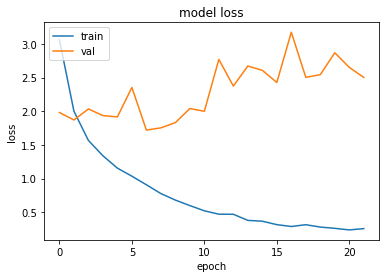

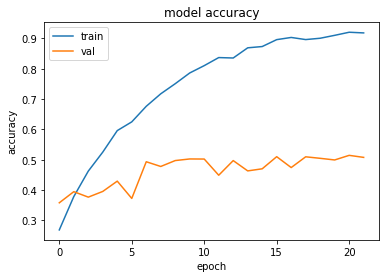

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  6 when  Val Loss was:  1.7199517488479614 , and Val Acc happened to be 0.49320000410079956
Additionally, the best val acc epoch happened to be  20 when val acc was:  0.5142999887466431 and Val Loss happened to be  2.650501251220703
TestLoss:  1.7331959009170532  TestAcc: 0.490200012922287
frog 0.808
ship 0.745
horse 0.626
automobile 0.593
truck 0.574
deer 0.388
dog 0.379
airplane 0.349
bird 0.322
cat 0.118


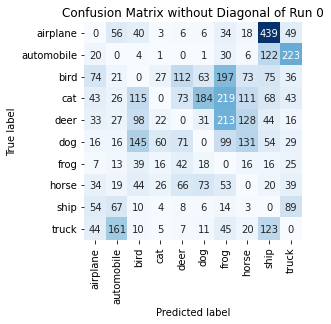

Summing down the rows, for Predictions of each Class that were wrong:  [325. 406. 505. 164. 385. 393. 904. 506. 961. 549.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  112.0 times
Summing across the columns, for total number of that True Class misidentified:  [651. 407. 678. 882. 612. 621. 192. 374. 255. 426.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  213.0 times

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

   Begin Run:  1 on Dataset TrainA_Zipped

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 

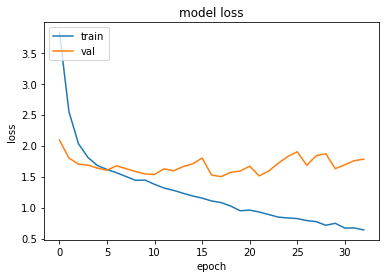

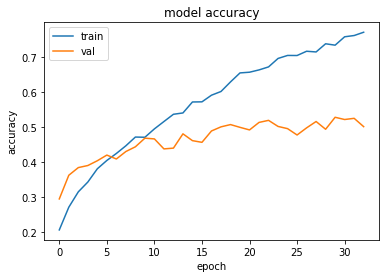

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  17 when  Val Loss was:  1.4996113777160645 , and Val Acc happened to be 0.5
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.527400016784668 and Val Loss happened to be  1.6283503770828247
TestLoss:  1.4840501546859741  TestAcc: 0.5026000142097473
frog 0.735
dog 0.666
ship 0.664
horse 0.591
truck 0.581
automobile 0.537
deer 0.379
airplane 0.369
bird 0.304
cat 0.2


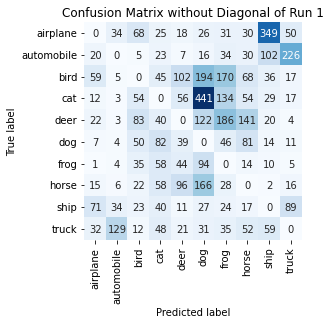

Summing down the rows, for Predictions of each Class that were wrong:  [ 239.  222.  352.  419.  394. 1117.  688.  487.  621.  435.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  102.0 times
Summing across the columns, for total number of that True Class misidentified:  [631. 463. 696. 800. 621. 334. 265. 409. 336. 419.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  186.0 times

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

   Begin Run:  2 on Dataset TrainA_Zipped

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 0 , 0 )
blur:     ( 3 , 3 )
sharp:    ( 0.0 , 0.0 )
Co

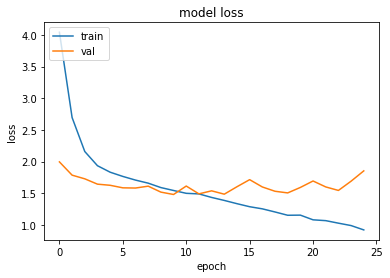

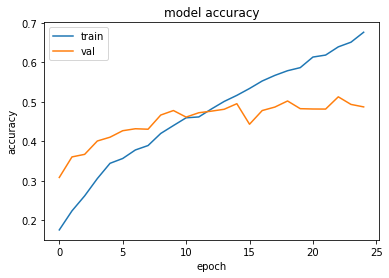

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  9 when  Val Loss was:  1.479033350944519 , and Val Acc happened to be 0.4781999886035919
Additionally, the best val acc epoch happened to be  22 when val acc was:  0.5128999948501587 and Val Loss happened to be  1.542999029159546
TestLoss:  1.4593181610107422  TestAcc: 0.47450000047683716
truck 0.773
frog 0.667
dog 0.656
horse 0.647
ship 0.555
automobile 0.489
deer 0.382
airplane 0.318
bird 0.145
cat 0.113


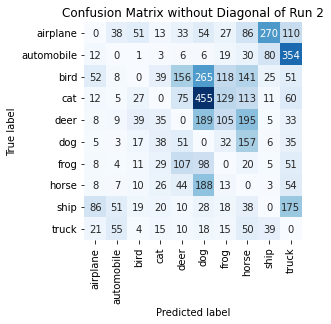

Summing down the rows, for Predictions of each Class that were wrong:  [ 212.  180.  179.  218.  492. 1301.  476.  830.  444.  923.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  156.0 times
Summing across the columns, for total number of that True Class misidentified:  [682. 511. 855. 887. 618. 344. 333. 353. 445. 227.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  195.0 times

 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

   Begin Run:  3 on Dataset TrainA_Zipped

 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 0 , 0 )
blur:     ( 0 , 1 )
sharp:    ( 0.1 ,

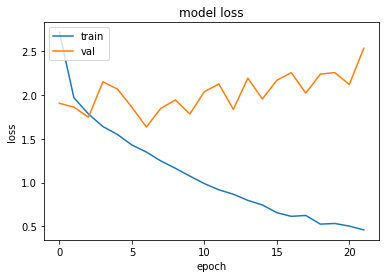

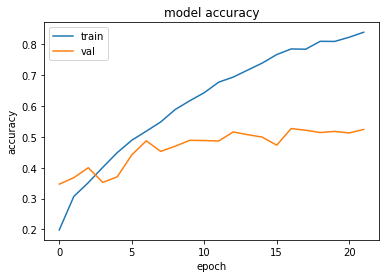

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  6 when  Val Loss was:  1.635898232460022 , and Val Acc happened to be 0.487199991941452
Additionally, the best val acc epoch happened to be  16 when val acc was:  0.5270000100135803 and Val Loss happened to be  2.2569239139556885
TestLoss:  1.612835168838501  TestAcc: 0.48249998688697815
truck 0.735
frog 0.682
horse 0.664
automobile 0.662
ship 0.542
dog 0.519
deer 0.402
bird 0.242
airplane 0.233
cat 0.144


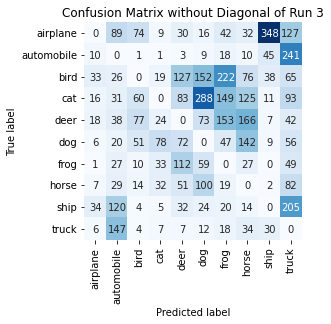

Summing down the rows, for Predictions of each Class that were wrong:  [131. 527. 295. 208. 517. 733. 688. 626. 490. 960.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  127.0 times
Summing across the columns, for total number of that True Class misidentified:  [767. 338. 758. 856. 598. 481. 318. 336. 458. 265.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  166.0 times

 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

   Begin Run:  4 on Dataset TrainA_Zipped

 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 12 , 12 )
blur:     ( 3 , 3 )
sharp:    ( 0.0

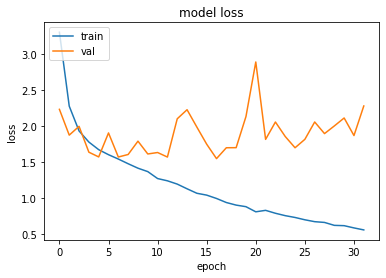

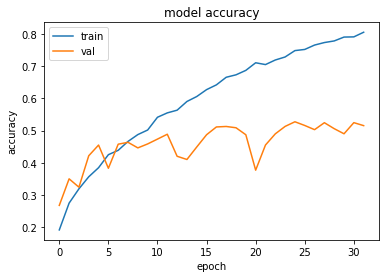

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  16 when  Val Loss was:  1.5487290620803833 , and Val Acc happened to be 0.5110999941825867
Additionally, the best val acc epoch happened to be  24 when val acc was:  0.5271999835968018 and Val Loss happened to be  1.6991547346115112
TestLoss:  1.5264638662338257  TestAcc: 0.5206999778747559
dog 0.702
ship 0.677
truck 0.641
horse 0.635
frog 0.625
automobile 0.526
airplane 0.437
deer 0.435
bird 0.395
cat 0.134


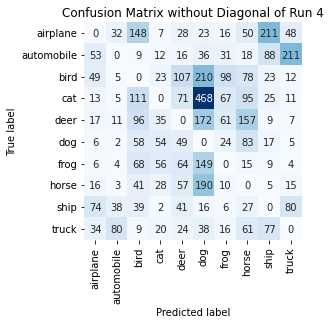

Summing down the rows, for Predictions of each Class that were wrong:  [ 268.  180.  579.  237.  457. 1302.  329.  584.  464.  393.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  107.0 times
Summing across the columns, for total number of that True Class misidentified:  [563. 474. 605. 866. 565. 298. 375. 365. 323. 359.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  172.0 times

 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

   Begin Run:  5 on Dataset TrainA_Zipped

 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 0 , 0 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
C

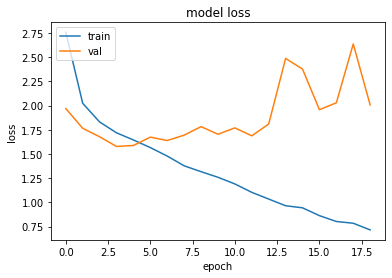

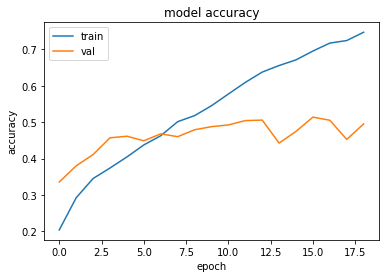

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  3 when  Val Loss was:  1.57716965675354 , and Val Acc happened to be 0.4569000005722046
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.513700008392334 and Val Loss happened to be  1.9571276903152466
TestLoss:  1.5647351741790771  TestAcc: 0.4560999870300293
frog 0.719
ship 0.693
dog 0.615
horse 0.615
truck 0.569
automobile 0.483
airplane 0.331
bird 0.217
deer 0.186
cat 0.133


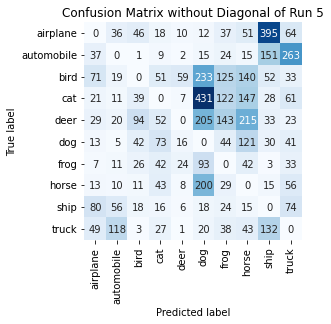

Summing down the rows, for Predictions of each Class that were wrong:  [ 320.  286.  280.  331.  133. 1227.  586.  789.  839.  648.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  59.0 times
Summing across the columns, for total number of that True Class misidentified:  [669. 517. 783. 867. 814. 385. 281. 385. 307. 431.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  215.0 times

 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

   Begin Run:  6 on Dataset TrainA_Zipped

 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.1 , 

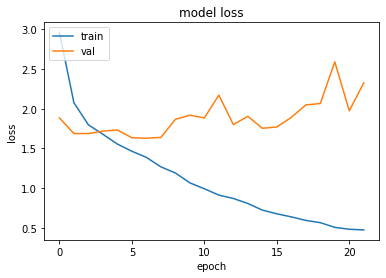

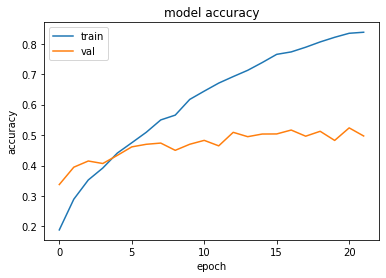

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  6 when  Val Loss was:  1.628017544746399 , and Val Acc happened to be 0.4697999954223633
Additionally, the best val acc epoch happened to be  20 when val acc was:  0.5236999988555908 and Val Loss happened to be  1.973159909248352
TestLoss:  1.6164979934692383  TestAcc: 0.4641999900341034
ship 0.785
frog 0.686
dog 0.656
horse 0.635
truck 0.577
automobile 0.431
airplane 0.375
deer 0.216
bird 0.18
cat 0.101


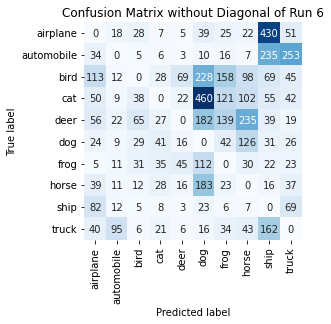

Summing down the rows, for Predictions of each Class that were wrong:  [ 443.  199.  219.  201.  185. 1253.  564.  670. 1059.  565.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  69.0 times
Summing across the columns, for total number of that True Class misidentified:  [625. 569. 820. 899. 784. 344. 314. 365. 215. 423.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  235.0 times

 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

   Begin Run:  7 on Dataset TrainA_Zipped

 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 24 , 24 )
blur:     ( 0 , 1 )
sharp:    ( 0.1 

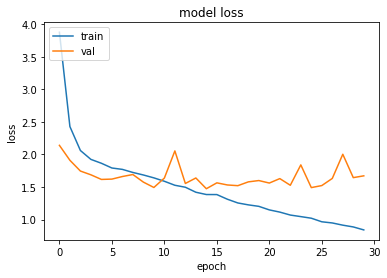

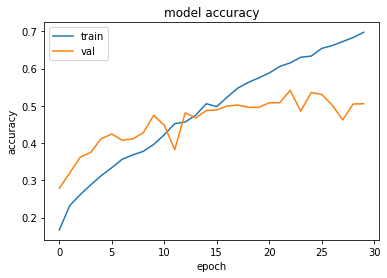

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  14 when  Val Loss was:  1.4735736846923828 , and Val Acc happened to be 0.48739999532699585
Additionally, the best val acc epoch happened to be  22 when val acc was:  0.541700005531311 and Val Loss happened to be  1.526586890220642
TestLoss:  1.4395058155059814  TestAcc: 0.49950000643730164
dog 0.751
horse 0.686
frog 0.671
truck 0.661
ship 0.57
airplane 0.534
automobile 0.423
bird 0.368
deer 0.254
cat 0.077


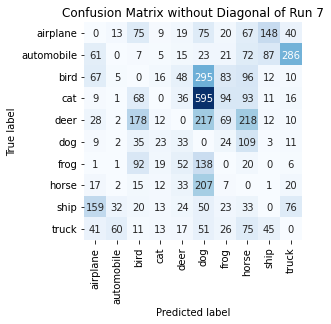

Summing down the rows, for Predictions of each Class that were wrong:  [ 392.  118.  501.  122.  277. 1651.  367.  783.  319.  475.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  52.0 times
Summing across the columns, for total number of that True Class misidentified:  [466. 577. 632. 923. 746. 249. 329. 314. 430. 339.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  218.0 times

 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

   Begin Run:  8 on Dataset TrainA_Zipped

 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Co

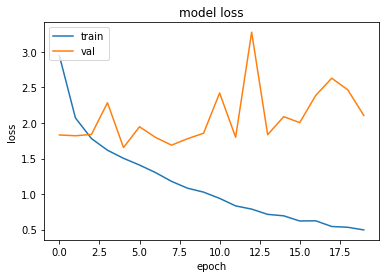

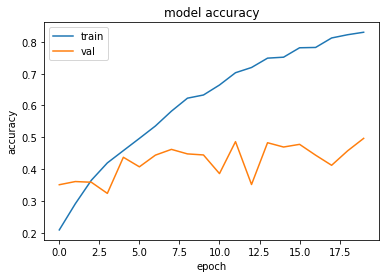

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.6550185680389404 , and Val Acc happened to be 0.4372999966144562
Additionally, the best val acc epoch happened to be  19 when val acc was:  0.4966999888420105 and Val Loss happened to be  2.1068146228790283
TestLoss:  1.6410177946090698  TestAcc: 0.4293999969959259
frog 0.846
ship 0.683
horse 0.603
truck 0.575
dog 0.459
bird 0.354
deer 0.25
automobile 0.236
airplane 0.23
cat 0.058


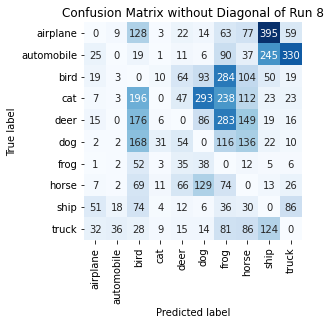

Summing down the rows, for Predictions of each Class that were wrong:  [ 159.   75.  910.   78.  326.  679. 1265.  743.  896.  575.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  66.0 times
Summing across the columns, for total number of that True Class misidentified:  [770. 764. 646. 942. 750. 541. 154. 397. 317. 425.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  283.0 times

 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 

   Begin Run:  9 on Dataset TrainA_Zipped

 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 12 , 12 )
blur:     ( 3 , 3 )
sharp: 

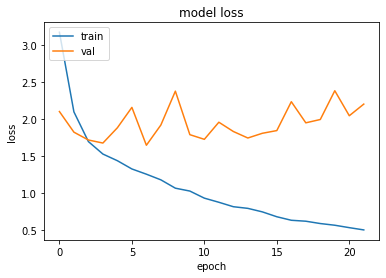

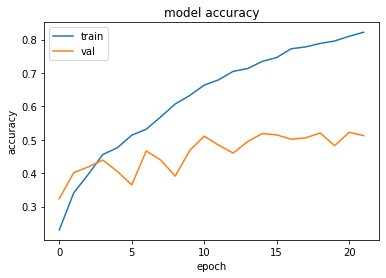

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  6 when  Val Loss was:  1.6461554765701294 , and Val Acc happened to be 0.4666999876499176
Additionally, the best val acc epoch happened to be  20 when val acc was:  0.5223000049591064 and Val Loss happened to be  2.0446524620056152
TestLoss:  1.6065467596054077  TestAcc: 0.47200000286102295
ship 0.649
frog 0.643
horse 0.632
truck 0.565
deer 0.546
dog 0.48
automobile 0.463
bird 0.41
airplane 0.297
cat 0.035


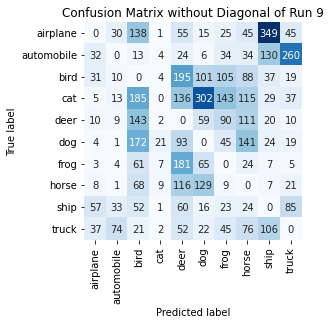

Summing down the rows, for Predictions of each Class that were wrong:  [187. 175. 853.  51. 912. 715. 519. 658. 709. 501.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  195.0 times
Summing across the columns, for total number of that True Class misidentified:  [703. 537. 590. 965. 454. 520. 357. 368. 351. 435.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  143.0 times

 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 

   Begin Run:  10 on Dataset TrainA_Zipped

 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:  

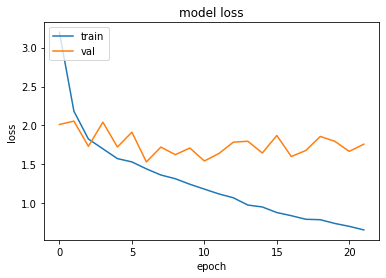

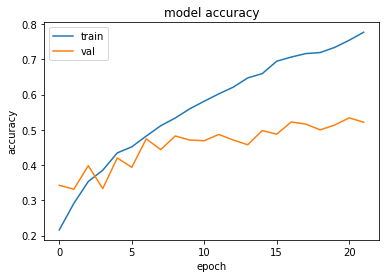

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  6 when  Val Loss was:  1.53236722946167 , and Val Acc happened to be 0.47450000047683716
Additionally, the best val acc epoch happened to be  20 when val acc was:  0.5338000059127808 and Val Loss happened to be  1.667598009109497
TestLoss:  1.5208678245544434  TestAcc: 0.47600001096725464
frog 0.726
horse 0.685
ship 0.683
truck 0.606
dog 0.566
automobile 0.559
deer 0.382
bird 0.237
airplane 0.211
cat 0.105


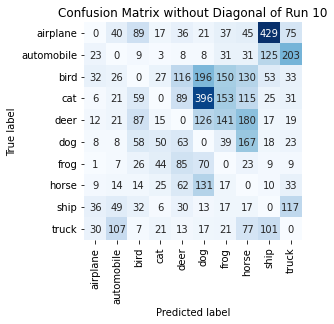

Summing down the rows, for Predictions of each Class that were wrong:  [157. 293. 381. 208. 502. 978. 606. 785. 787. 543.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  116.0 times
Summing across the columns, for total number of that True Class misidentified:  [789. 441. 763. 895. 618. 434. 274. 315. 317. 394.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  180.0 times

 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 

   Begin Run:  11 on Dataset TrainA_Zipped

 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn

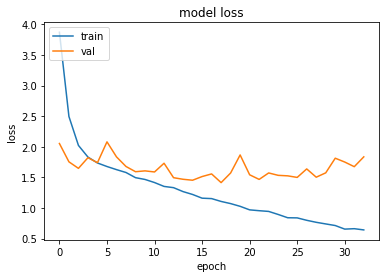

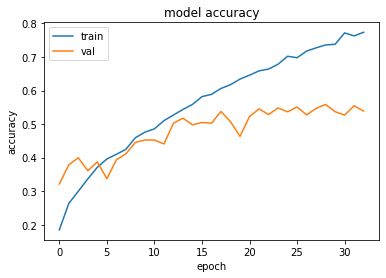

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  17 when  Val Loss was:  1.4150431156158447 , and Val Acc happened to be 0.5376999974250793
Additionally, the best val acc epoch happened to be  28 when val acc was:  0.5586000084877014 and Val Loss happened to be  1.5748071670532227
TestLoss:  1.3953882455825806  TestAcc: 0.5318999886512756
frog 0.797
ship 0.778
truck 0.689
dog 0.594
automobile 0.572
horse 0.559
deer 0.427
bird 0.321
airplane 0.3
cat 0.282


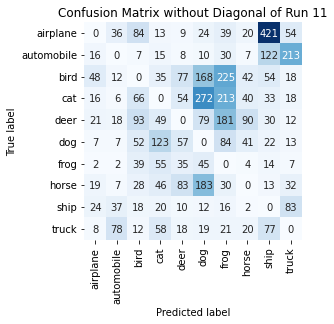

Summing down the rows, for Predictions of each Class that were wrong:  [161. 203. 399. 414. 351. 812. 839. 266. 786. 450.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  83.0 times
Summing across the columns, for total number of that True Class misidentified:  [700. 428. 679. 718. 573. 406. 203. 441. 222. 311.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  181.0 times

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 

   Begin Run:  12 on Dataset TrainA_Zipped

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.08 , -0.08 )


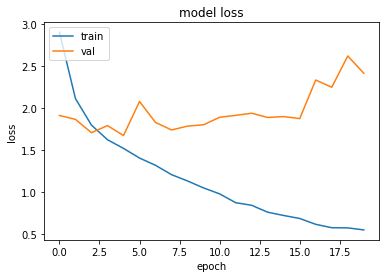

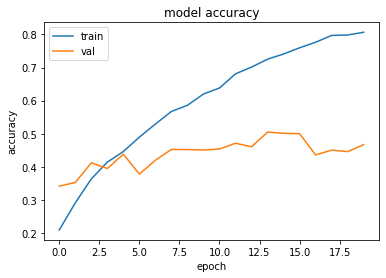

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.6770542860031128 , and Val Acc happened to be 0.43790000677108765
Additionally, the best val acc epoch happened to be  13 when val acc was:  0.5047000050544739 and Val Loss happened to be  1.8920409679412842
TestLoss:  1.6437898874282837  TestAcc: 0.44020000100135803
frog 0.688
horse 0.655
truck 0.622
dog 0.549
ship 0.547
deer 0.41
automobile 0.406
airplane 0.306
bird 0.143
cat 0.076


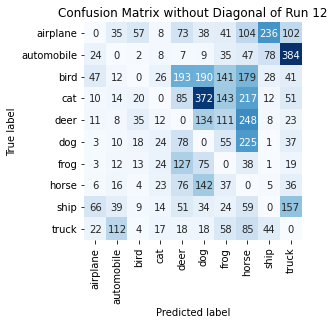

Summing down the rows, for Predictions of each Class that were wrong:  [ 192.  258.  162.  156.  708. 1012.  645. 1202.  413.  850.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  193.0 times
Summing across the columns, for total number of that True Class misidentified:  [694. 594. 857. 924. 590. 451. 312. 345. 453. 378.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  248.0 times

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 

   Begin Run:  13 on Dataset TrainA_Zipped

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0

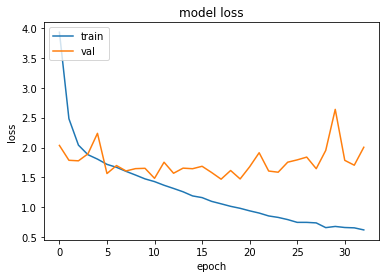

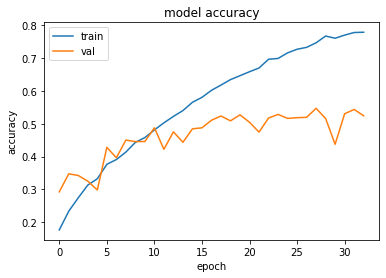

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  17 when  Val Loss was:  1.4717957973480225 , and Val Acc happened to be 0.5235999822616577
Additionally, the best val acc epoch happened to be  27 when val acc was:  0.546999990940094 and Val Loss happened to be  1.6469488143920898
TestLoss:  1.457576870918274  TestAcc: 0.5216000080108643
frog 0.718
ship 0.659
horse 0.651
automobile 0.624
dog 0.577
truck 0.542
airplane 0.535
bird 0.477
deer 0.404
cat 0.029


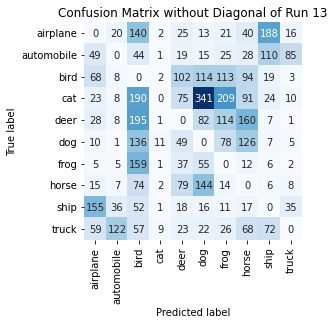

Summing down the rows, for Predictions of each Class that were wrong:  [ 412.  215. 1047.   30.  427.  802.  611.  636.  439.  165.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  102.0 times
Summing across the columns, for total number of that True Class misidentified:  [465. 376. 523. 971. 596. 423. 282. 349. 341. 458.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  195.0 times

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 

   Begin Run:  14 on Dataset TrainA_Zipped

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -

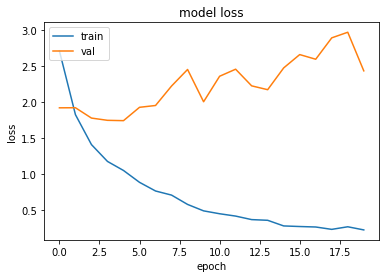

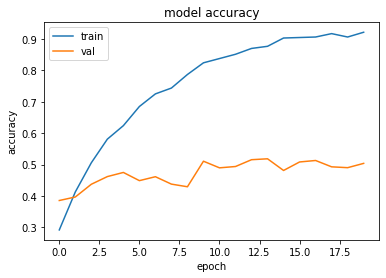

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.739668607711792 , and Val Acc happened to be 0.4749000072479248
Additionally, the best val acc epoch happened to be  13 when val acc was:  0.5184000134468079 and Val Loss happened to be  2.1685590744018555
TestLoss:  1.7162624597549438  TestAcc: 0.47699999809265137
frog 0.749
truck 0.659
ship 0.608
horse 0.573
automobile 0.567
deer 0.474
dog 0.388
airplane 0.289
cat 0.276
bird 0.187


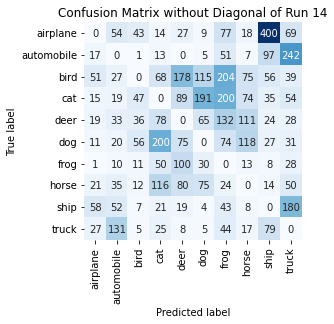

Summing down the rows, for Predictions of each Class that were wrong:  [220. 381. 218. 585. 576. 499. 849. 441. 740. 721.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  178.0 times
Summing across the columns, for total number of that True Class misidentified:  [711. 433. 813. 724. 526. 612. 251. 427. 392. 341.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  132.0 times

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 

   Begin Run:  15 on Dataset TrainA_Zipped

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.

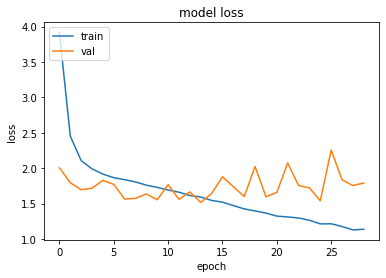

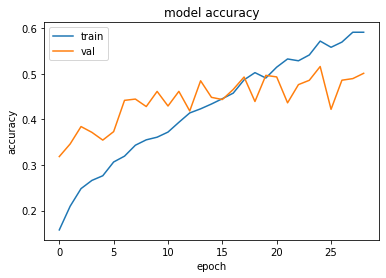

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  13 when  Val Loss was:  1.516206979751587 , and Val Acc happened to be 0.4846999943256378
Additionally, the best val acc epoch happened to be  24 when val acc was:  0.515999972820282 and Val Loss happened to be  1.539607048034668
TestLoss:  1.5116784572601318  TestAcc: 0.4763000011444092
dog 0.734
ship 0.73
frog 0.661
truck 0.587
horse 0.554
automobile 0.393
airplane 0.387
deer 0.386
bird 0.214
cat 0.117


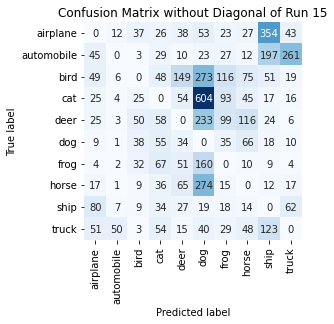

Summing down the rows, for Predictions of each Class that were wrong:  [ 305.   86.  206.  407.  443. 1679.  455.  413.  805.  438.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  149.0 times
Summing across the columns, for total number of that True Class misidentified:  [613. 607. 786. 883. 614. 266. 339. 446. 270. 413.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  233.0 times

 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 

   Begin Run:  16 on Dataset TrainA_Zipped

 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 

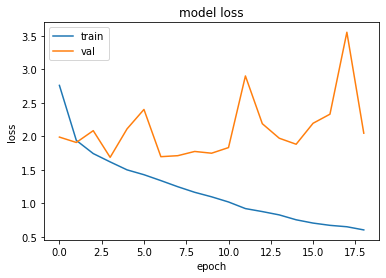

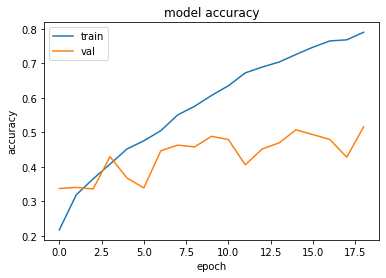

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  3 when  Val Loss was:  1.684449553489685 , and Val Acc happened to be 0.42980000376701355
Additionally, the best val acc epoch happened to be  18 when val acc was:  0.5163999795913696 and Val Loss happened to be  2.044895887374878
TestLoss:  1.6757732629776  TestAcc: 0.4242999851703644
frog 0.827
dog 0.734
ship 0.593
truck 0.561
horse 0.39
deer 0.334
automobile 0.317
airplane 0.299
bird 0.119
cat 0.069


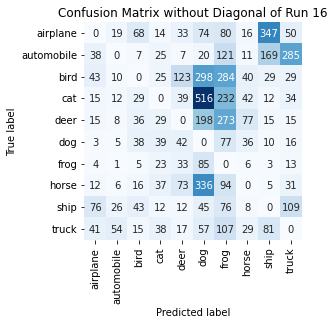

Summing down the rows, for Predictions of each Class that were wrong:  [ 247.  141.  257.  242.  379. 1629. 1344.  265.  671.  582.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  123.0 times
Summing across the columns, for total number of that True Class misidentified:  [701. 683. 881. 931. 666. 266. 173. 610. 407. 439.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  273.0 times

 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 

   Begin Run:  17 on Dataset TrainA_Zipped

 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut: 

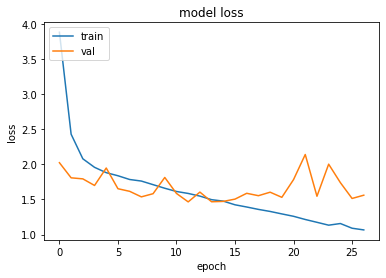

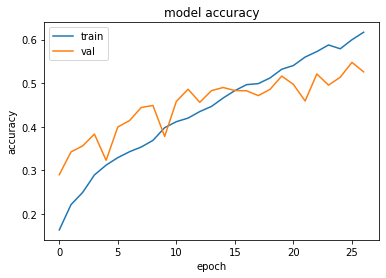

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  11 when  Val Loss was:  1.465513825416565 , and Val Acc happened to be 0.4860999882221222
Additionally, the best val acc epoch happened to be  25 when val acc was:  0.5478000044822693 and Val Loss happened to be  1.5143229961395264
TestLoss:  1.4457556009292603  TestAcc: 0.48190000653266907
frog 0.716
dog 0.672
horse 0.663
ship 0.663
truck 0.655
automobile 0.453
deer 0.367
airplane 0.296
bird 0.181
cat 0.153


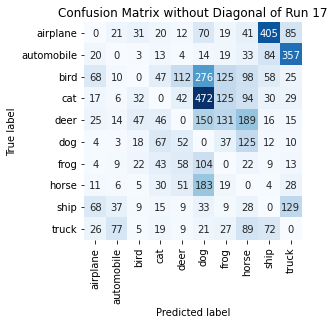

Summing down the rows, for Predictions of each Class that were wrong:  [ 243.  183.  172.  300.  349. 1323.  511.  719.  690.  691.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  112.0 times
Summing across the columns, for total number of that True Class misidentified:  [704. 547. 819. 847. 633. 328. 284. 337. 337. 345.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  189.0 times

 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 

   Begin Run:  18 on Dataset TrainA_Zipped

 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.1

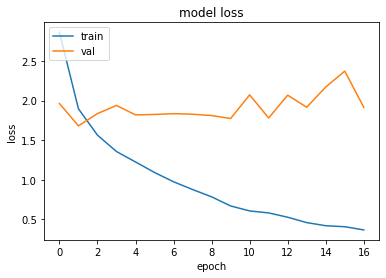

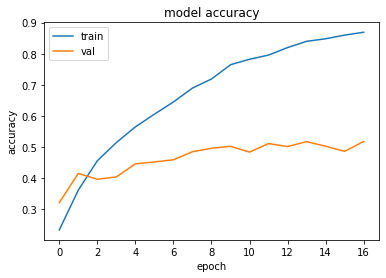

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  1 when  Val Loss was:  1.681701421737671 , and Val Acc happened to be 0.4154999852180481
Additionally, the best val acc epoch happened to be  16 when val acc was:  0.5178999900817871 and Val Loss happened to be  1.9153681993484497
TestLoss:  1.6683012247085571  TestAcc: 0.4154999852180481
ship 0.672
frog 0.639
horse 0.632
dog 0.629
automobile 0.485
truck 0.33
bird 0.288
airplane 0.286
deer 0.166
cat 0.028


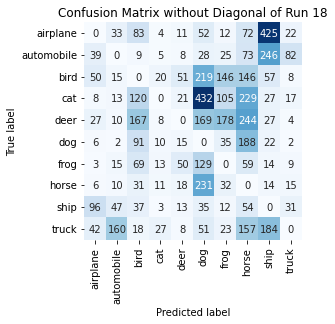

Summing down the rows, for Predictions of each Class that were wrong:  [ 277.  305.  625.  101.  195. 1346.  568. 1222. 1016.  190.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  51.0 times
Summing across the columns, for total number of that True Class misidentified:  [714. 515. 712. 972. 834. 371. 361. 368. 328. 670.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  244.0 times

 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 

   Begin Run:  19 on Dataset TrainA_Zipped

 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16

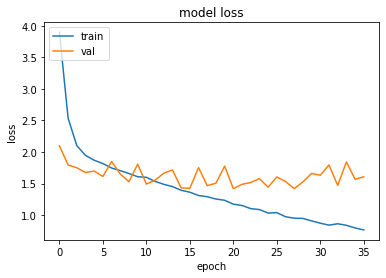

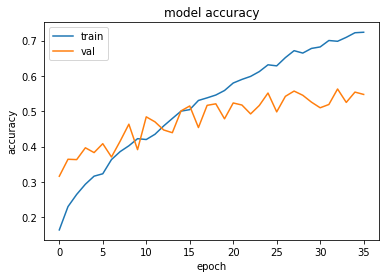

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  20 when  Val Loss was:  1.4189919233322144 , and Val Acc happened to be 0.5235000252723694
Additionally, the best val acc epoch happened to be  32 when val acc was:  0.5630999803543091 and Val Loss happened to be  1.4715538024902344
TestLoss:  1.3985499143600464  TestAcc: 0.5299000144004822
ship 0.802
truck 0.703
horse 0.678
deer 0.613
frog 0.554
automobile 0.552
dog 0.532
airplane 0.365
bird 0.311
cat 0.189


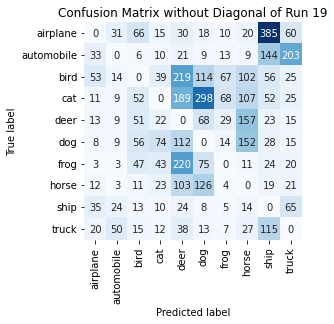

Summing down the rows, for Predictions of each Class that were wrong:  [188. 152. 317. 248. 956. 729. 217. 599. 846. 449.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  220.0 times
Summing across the columns, for total number of that True Class misidentified:  [635. 448. 689. 811. 387. 468. 446. 322. 198. 297.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  157.0 times

 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 

   Begin Run:  20 on Dataset TrainA_Zipped

 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn

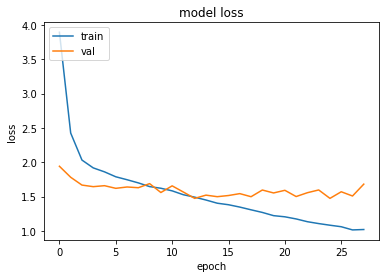

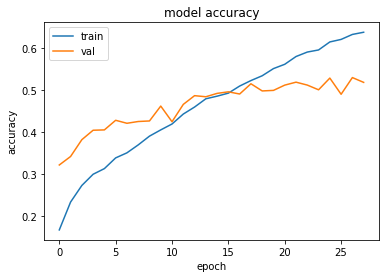

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  12 when  Val Loss was:  1.473694086074829 , and Val Acc happened to be 0.4862000048160553
Additionally, the best val acc epoch happened to be  26 when val acc was:  0.5291000008583069 and Val Loss happened to be  1.50838041305542
TestLoss:  1.4468424320220947  TestAcc: 0.4837999939918518
frog 0.739
ship 0.613
dog 0.592
horse 0.576
truck 0.559
automobile 0.49
deer 0.475
airplane 0.393
bird 0.283
cat 0.118


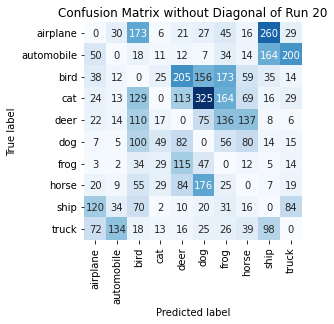

Summing down the rows, for Predictions of each Class that were wrong:  [356. 253. 707. 181. 658. 858. 690. 442. 607. 410.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  205.0 times
Summing across the columns, for total number of that True Class misidentified:  [607. 510. 717. 882. 525. 408. 261. 424. 387. 441.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  137.0 times

 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 

   Begin Run:  21 on Dataset TrainA_Zipped

 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 ,

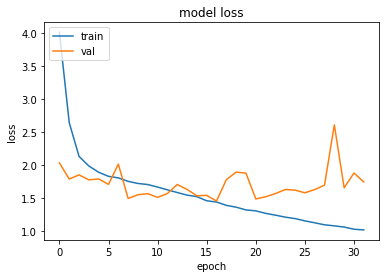

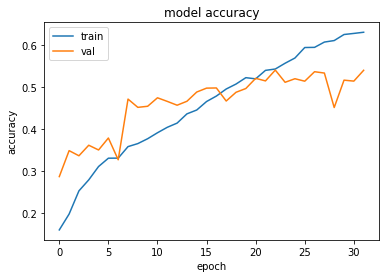

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  16 when  Val Loss was:  1.4504066705703735 , and Val Acc happened to be 0.4984999895095825
Additionally, the best val acc epoch happened to be  22 when val acc was:  0.541100025177002 and Val Loss happened to be  1.5635266304016113
TestLoss:  1.4278699159622192  TestAcc: 0.4970000088214874
truck 0.741
dog 0.696
ship 0.648
horse 0.585
frog 0.532
automobile 0.441
deer 0.426
bird 0.421
airplane 0.284
cat 0.196


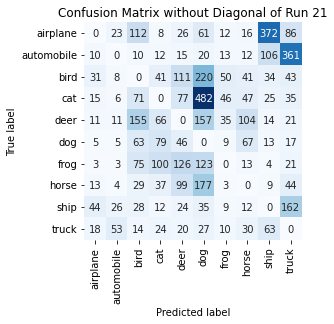

Summing down the rows, for Predictions of each Class that were wrong:  [ 150.  139.  557.  379.  544. 1302.  187.  342.  640.  790.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  126.0 times
Summing across the columns, for total number of that True Class misidentified:  [716. 559. 579. 804. 574. 304. 468. 415. 352. 259.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  157.0 times

 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 

   Begin Run:  22 on Dataset TrainA_Zipped

 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )


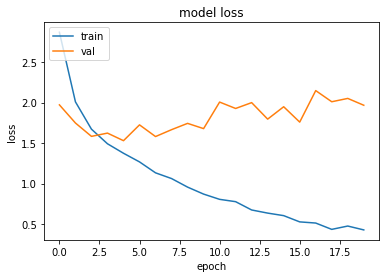

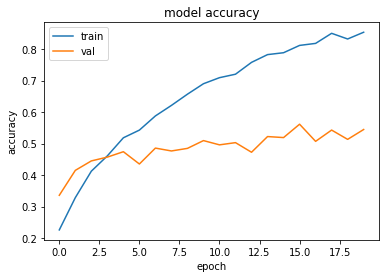

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.5297383069992065 , and Val Acc happened to be 0.4742000102996826
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.5615000128746033 and Val Loss happened to be  1.758881688117981
TestLoss:  1.5440973043441772  TestAcc: 0.47049999237060547
frog 0.889
truck 0.669
ship 0.62
horse 0.586
automobile 0.489
dog 0.442
deer 0.441
airplane 0.312
cat 0.129
bird 0.128


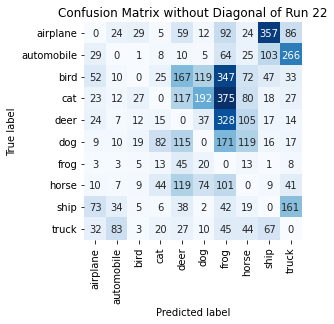

Summing down the rows, for Predictions of each Class that were wrong:  [ 255.  190.  110.  218.  697.  471. 1565.  501.  635.  653.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  167.0 times
Summing across the columns, for total number of that True Class misidentified:  [688. 511. 872. 871. 559. 558. 111. 414. 380. 331.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  328.0 times

 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 

   Begin Run:  23 on Dataset TrainA_Zipped

 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 

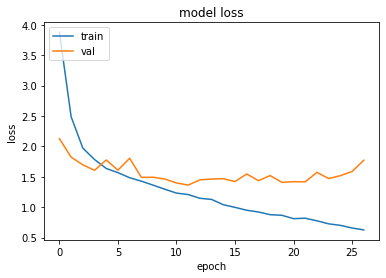

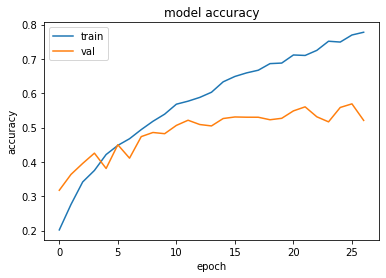

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  11 when  Val Loss was:  1.3636747598648071 , and Val Acc happened to be 0.5214999914169312
Additionally, the best val acc epoch happened to be  25 when val acc was:  0.5691999793052673 and Val Loss happened to be  1.586875319480896
TestLoss:  1.3441150188446045  TestAcc: 0.5192000269889832
dog 0.782
ship 0.768
frog 0.741
automobile 0.687
truck 0.632
horse 0.567
deer 0.337
airplane 0.335
bird 0.281
cat 0.062


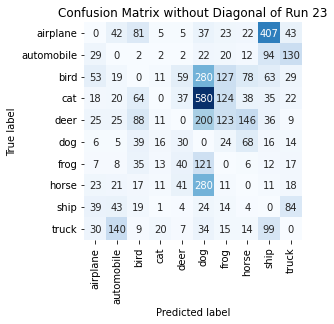

Summing down the rows, for Predictions of each Class that were wrong:  [ 230.  323.  354.   90.  225. 1578.  481.  388.  773.  366.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  59.0 times
Summing across the columns, for total number of that True Class misidentified:  [665. 313. 719. 938. 663. 218. 259. 433. 232. 368.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  200.0 times

 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 

   Begin Run:  24 on Dataset TrainA_Zipped

 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )

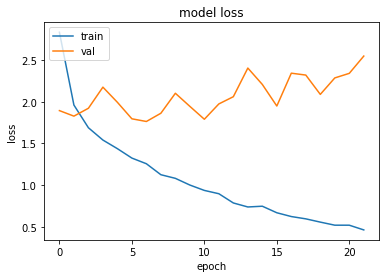

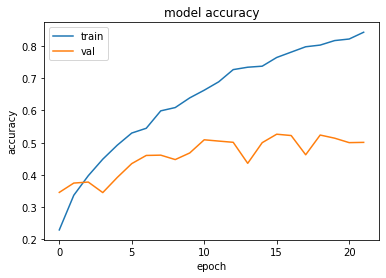

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  6 when  Val Loss was:  1.762655258178711 , and Val Acc happened to be 0.4603999853134155
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.526199996471405 and Val Loss happened to be  1.9476945400238037
TestLoss:  1.73868989944458  TestAcc: 0.46320000290870667
horse 0.728
frog 0.64
ship 0.621
dog 0.604
truck 0.534
airplane 0.444
deer 0.394
bird 0.293
automobile 0.267
cat 0.107


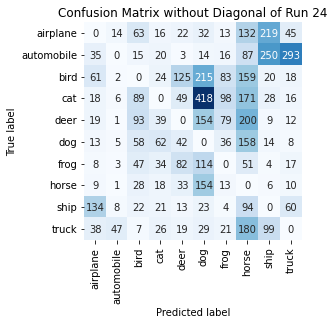

Summing down the rows, for Predictions of each Class that were wrong:  [ 335.   87.  422.  260.  388. 1153.  363. 1232.  649.  479.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  125.0 times
Summing across the columns, for total number of that True Class misidentified:  [556. 733. 707. 893. 606. 396. 360. 272. 379. 466.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  200.0 times

 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 

   Begin Run:  25 on Dataset TrainA_Zipped

 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:

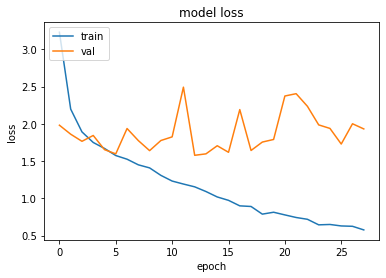

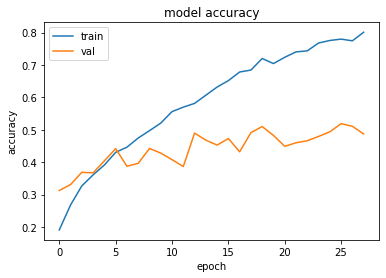

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  12 when  Val Loss was:  1.5775052309036255 , and Val Acc happened to be 0.48980000615119934
Additionally, the best val acc epoch happened to be  25 when val acc was:  0.5188999772071838 and Val Loss happened to be  1.7288304567337036
TestLoss:  1.5649586915969849  TestAcc: 0.4860999882221222
ship 0.751
truck 0.683
horse 0.668
frog 0.64
dog 0.515
automobile 0.492
deer 0.389
airplane 0.294
cat 0.239
bird 0.19


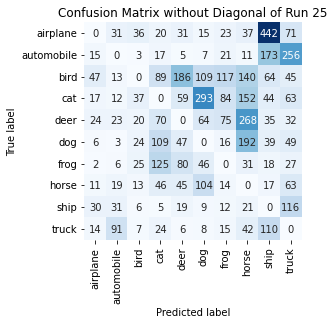

Summing down the rows, for Predictions of each Class that were wrong:  [166. 229. 171. 505. 478. 655. 377. 894. 942. 722.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  186.0 times
Summing across the columns, for total number of that True Class misidentified:  [706. 508. 810. 761. 611. 485. 360. 332. 249. 317.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  268.0 times

 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 

   Begin Run:  26 on Dataset TrainA_Zipped

 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 ,

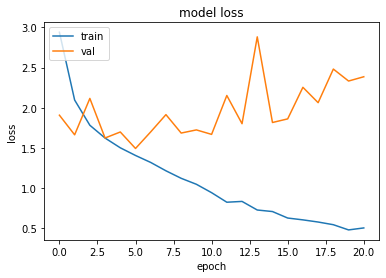

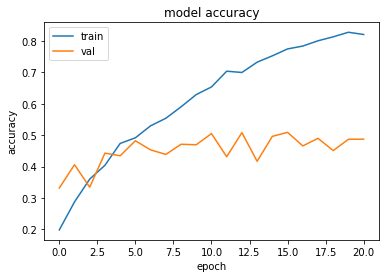

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  5 when  Val Loss was:  1.4928830862045288 , and Val Acc happened to be 0.48240000009536743
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.5091999769210815 and Val Loss happened to be  1.8613146543502808
TestLoss:  1.4775289297103882  TestAcc: 0.48179998993873596
frog 0.697
horse 0.655
ship 0.613
truck 0.604
automobile 0.544
deer 0.534
dog 0.351
airplane 0.329
cat 0.296
bird 0.195


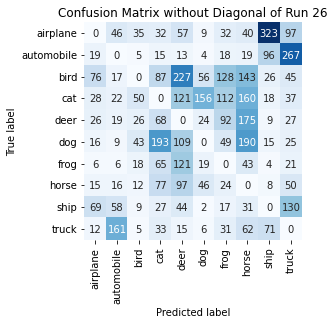

Summing down the rows, for Predictions of each Class that were wrong:  [267. 354. 203. 597. 804. 322. 503. 863. 570. 699.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  227.0 times
Summing across the columns, for total number of that True Class misidentified:  [671. 456. 805. 704. 466. 649. 303. 345. 387. 396.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  175.0 times

 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 

   Begin Run:  27 on Dataset TrainA_Zipped

 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 

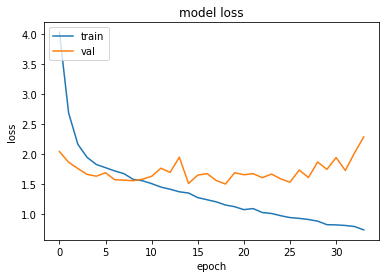

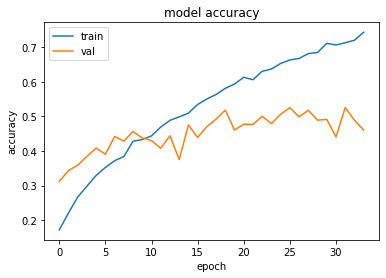

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  18 when  Val Loss was:  1.4977526664733887 , and Val Acc happened to be 0.5178999900817871
Additionally, the best val acc epoch happened to be  31 when val acc was:  0.5254999995231628 and Val Loss happened to be  1.7232394218444824
TestLoss:  1.4881677627563477  TestAcc: 0.5123000144958496
frog 0.785
truck 0.656
ship 0.639
automobile 0.636
dog 0.635
horse 0.479
airplane 0.396
bird 0.362
deer 0.357
cat 0.178


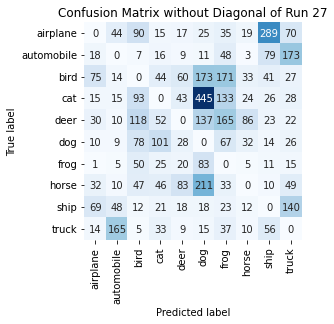

Summing down the rows, for Predictions of each Class that were wrong:  [ 264.  320.  500.  353.  287. 1118.  712.  224.  549.  550.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  83.0 times
Summing across the columns, for total number of that True Class misidentified:  [604. 364. 638. 822. 643. 365. 215. 521. 361. 344.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  165.0 times

 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 

   Begin Run:  28 on Dataset TrainA_Zipped

 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 

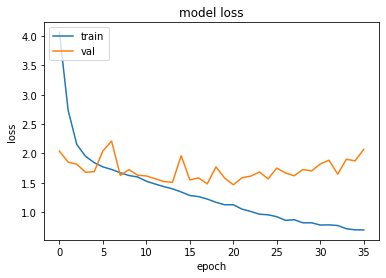

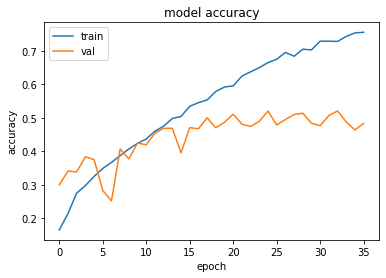

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  20 when  Val Loss was:  1.466966986656189 , and Val Acc happened to be 0.510699987411499
Additionally, the best val acc epoch happened to be  32 when val acc was:  0.5203999876976013 and Val Loss happened to be  1.646930456161499
TestLoss:  1.4326655864715576  TestAcc: 0.5098999738693237
ship 0.704
frog 0.689
truck 0.607
deer 0.596
automobile 0.578
horse 0.574
airplane 0.457
dog 0.427
cat 0.253
bird 0.214


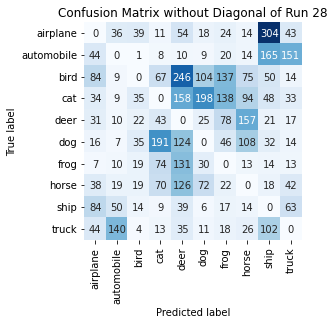

Summing down the rows, for Predictions of each Class that were wrong:  [382. 290. 188. 486. 923. 473. 500. 515. 754. 390.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  246.0 times
Summing across the columns, for total number of that True Class misidentified:  [543. 422. 786. 747. 404. 573. 311. 426. 296. 393.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  157.0 times

 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 

   Begin Run:  29 on Dataset TrainA_Zipped

 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )


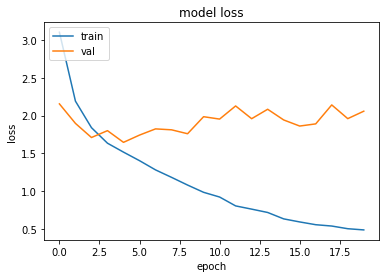

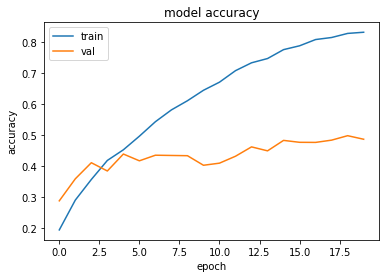

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.6457332372665405 , and Val Acc happened to be 0.43869999051094055
Additionally, the best val acc epoch happened to be  18 when val acc was:  0.49799999594688416 and Val Loss happened to be  1.9600627422332764
TestLoss:  1.6241737604141235  TestAcc: 0.4334999918937683
frog 0.811
ship 0.708
dog 0.59
truck 0.512
horse 0.448
automobile 0.377
airplane 0.345
deer 0.287
bird 0.203
cat 0.054


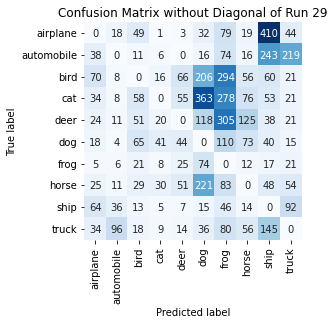

Summing down the rows, for Predictions of each Class that were wrong:  [ 312.  198.  315.  136.  265. 1081. 1349.  447. 1054.  508.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  66.0 times
Summing across the columns, for total number of that True Class misidentified:  [655. 623. 797. 946. 713. 410. 189. 552. 292. 488.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  305.0 times

 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 

   Begin Run:  30 on Dataset TrainA_Zipped

 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 

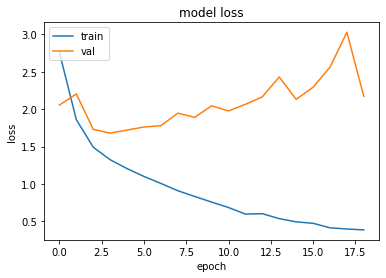

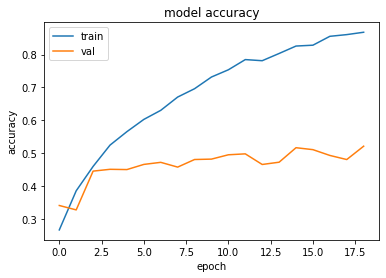

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  3 when  Val Loss was:  1.680617332458496 , and Val Acc happened to be 0.45100000500679016
Additionally, the best val acc epoch happened to be  18 when val acc was:  0.5213000178337097 and Val Loss happened to be  2.171421766281128
TestLoss:  1.656960368156433  TestAcc: 0.4496000111103058
horse 0.689
frog 0.655
ship 0.644
dog 0.563
truck 0.495
automobile 0.402
airplane 0.329
bird 0.296
deer 0.295
cat 0.128


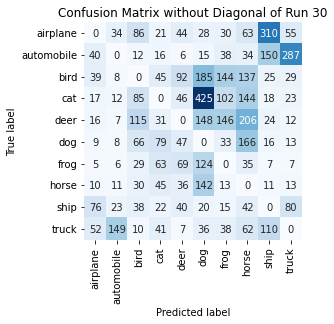

Summing down the rows, for Predictions of each Class that were wrong:  [ 264.  258.  471.  363.  387. 1123.  559.  889.  671.  519.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  92.0 times
Summing across the columns, for total number of that True Class misidentified:  [671. 598. 704. 872. 705. 437. 345. 311. 356. 505.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  206.0 times

 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 

   Begin Run:  31 on Dataset TrainA_Zipped

 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut: 

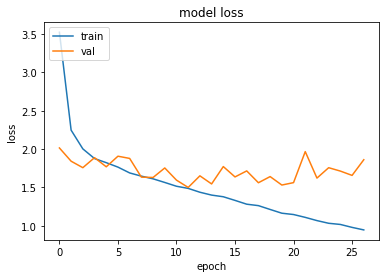

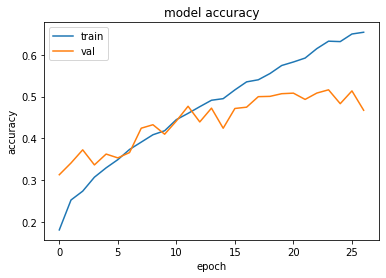

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  11 when  Val Loss was:  1.4990853071212769 , and Val Acc happened to be 0.47699999809265137
Additionally, the best val acc epoch happened to be  23 when val acc was:  0.5163999795913696 and Val Loss happened to be  1.7566579580307007
TestLoss:  1.47774076461792  TestAcc: 0.47530001401901245
frog 0.799
truck 0.775
dog 0.669
horse 0.661
ship 0.546
automobile 0.432
airplane 0.36
deer 0.338
bird 0.087
cat 0.086


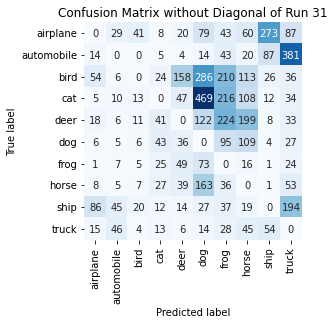

Summing down the rows, for Predictions of each Class that were wrong:  [ 207.  159.  107.  198.  373. 1247.  932.  689.  466.  869.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  158.0 times
Summing across the columns, for total number of that True Class misidentified:  [640. 568. 913. 914. 662. 331. 201. 339. 454. 225.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  224.0 times

 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 

   Begin Run:  32 on Dataset TrainA_Zipped

 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16

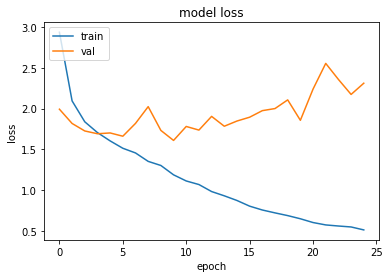

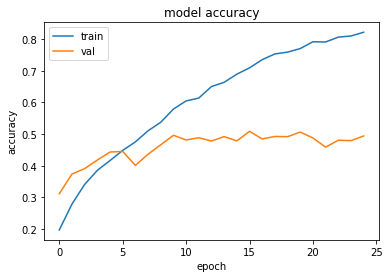

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  9 when  Val Loss was:  1.6091265678405762 , and Val Acc happened to be 0.49619999527931213
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.5087000131607056 and Val Loss happened to be  1.894102692604065
TestLoss:  1.6235976219177246  TestAcc: 0.48899999260902405
ship 0.77
horse 0.656
automobile 0.613
frog 0.609
dog 0.523
truck 0.427
airplane 0.407
deer 0.362
bird 0.321
cat 0.202


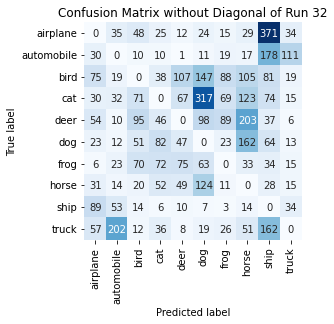

Summing down the rows, for Predictions of each Class that were wrong:  [ 395.  400.  391.  367.  376.  810.  343.  737. 1029.  262.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  107.0 times
Summing across the columns, for total number of that True Class misidentified:  [593. 387. 679. 798. 638. 477. 391. 344. 230. 573.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  203.0 times

 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 

   Begin Run:  33 on Dataset TrainA_Zipped

 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 

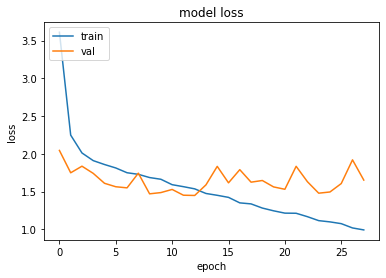

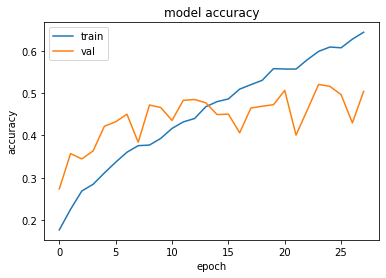

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  12 when  Val Loss was:  1.4488717317581177 , and Val Acc happened to be 0.48500001430511475
Additionally, the best val acc epoch happened to be  23 when val acc was:  0.5206000208854675 and Val Loss happened to be  1.4790319204330444
TestLoss:  1.4587135314941406  TestAcc: 0.47859999537467957
dog 0.787
ship 0.656
truck 0.633
frog 0.616
horse 0.612
automobile 0.591
airplane 0.316
deer 0.297
cat 0.143
bird 0.135


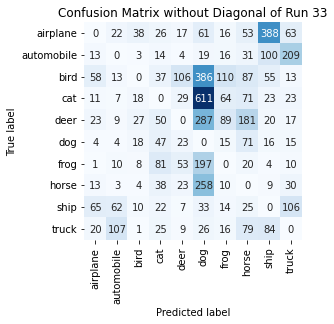

Summing down the rows, for Predictions of each Class that were wrong:  [ 208.  237.  127.  340.  271. 1878.  350.  618.  699.  486.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  106.0 times
Summing across the columns, for total number of that True Class misidentified:  [684. 409. 865. 857. 703. 213. 384. 388. 344. 367.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  287.0 times

 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 

   Begin Run:  34 on Dataset TrainA_Zipped

 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 

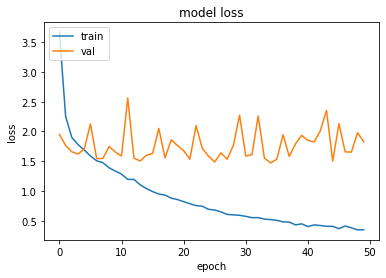

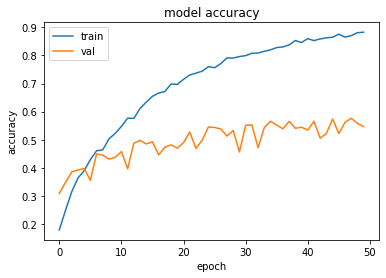

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  34 when  Val Loss was:  1.4715875387191772 , and Val Acc happened to be 0.5656999945640564
Additionally, the best val acc epoch happened to be  47 when val acc was:  0.576200008392334 and Val Loss happened to be  1.652905821800232
TestLoss:  1.460268497467041  TestAcc: 0.5637000203132629
ship 0.758
truck 0.675
automobile 0.654
dog 0.654
horse 0.624
frog 0.616
deer 0.523
bird 0.439
cat 0.37
airplane 0.324


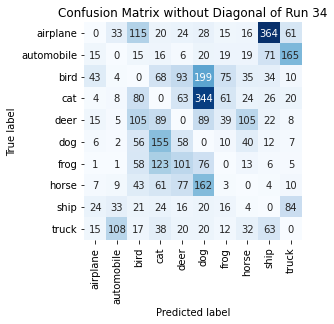

Summing down the rows, for Predictions of each Class that were wrong:  [130. 203. 510. 594. 458. 958. 250. 288. 602. 370.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  101.0 times
Summing across the columns, for total number of that True Class misidentified:  [676. 346. 561. 630. 477. 346. 384. 376. 242. 325.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  105.0 times

 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 

   Begin Run:  35 on Dataset TrainA_Zipped

 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )

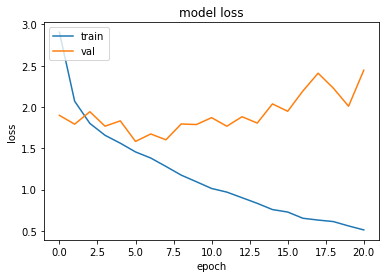

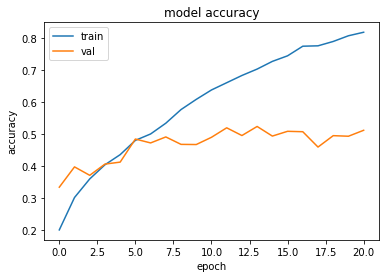

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  5 when  Val Loss was:  1.5824885368347168 , and Val Acc happened to be 0.4846999943256378
Additionally, the best val acc epoch happened to be  13 when val acc was:  0.5239999890327454 and Val Loss happened to be  1.8049756288528442
TestLoss:  1.5676681995391846  TestAcc: 0.4758000075817108
frog 0.768
ship 0.697
truck 0.677
dog 0.593
horse 0.496
automobile 0.48
deer 0.307
bird 0.269
airplane 0.262
cat 0.209


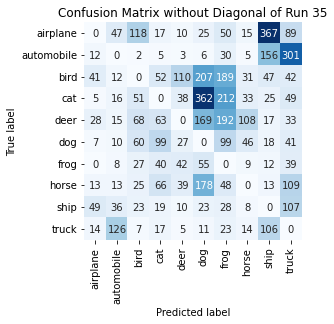

Summing down the rows, for Predictions of each Class that were wrong:  [ 169.  283.  381.  378.  284. 1036.  871.  269.  761.  810.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  110.0 times
Summing across the columns, for total number of that True Class misidentified:  [738. 520. 731. 791. 693. 407. 232. 504. 303. 323.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  192.0 times

 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 

   Begin Run:  36 on Dataset TrainA_Zipped

 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 

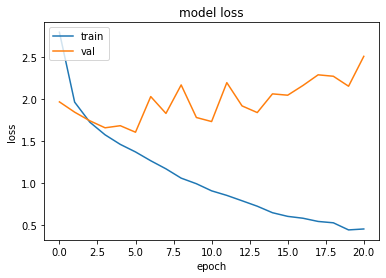

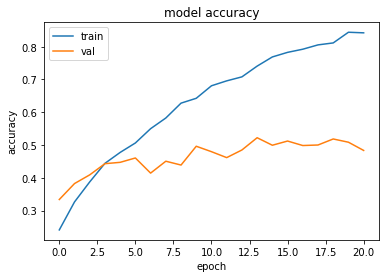

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  5 when  Val Loss was:  1.605615258216858 , and Val Acc happened to be 0.4603999853134155
Additionally, the best val acc epoch happened to be  13 when val acc was:  0.5221999883651733 and Val Loss happened to be  1.8386240005493164
TestLoss:  1.5790530443191528  TestAcc: 0.46209999918937683
frog 0.822
truck 0.71
dog 0.613
horse 0.601
ship 0.503
automobile 0.397
deer 0.349
airplane 0.299
bird 0.2
cat 0.127


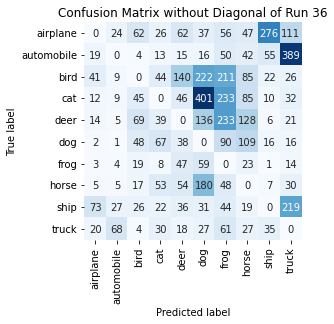

Summing down the rows, for Predictions of each Class that were wrong:  [ 189.  152.  294.  302.  456. 1109. 1026.  565.  428.  858.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  140.0 times
Summing across the columns, for total number of that True Class misidentified:  [701. 603. 800. 873. 651. 387. 178. 399. 497. 290.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  233.0 times

 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 

   Begin Run:  37 on Dataset TrainA_Zipped

 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut: 

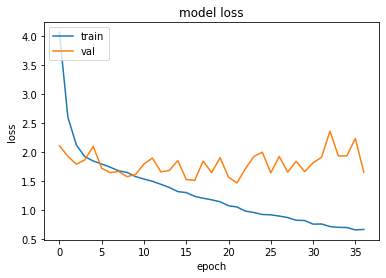

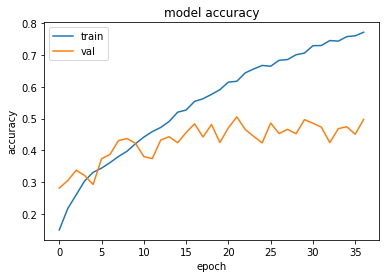

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  21 when  Val Loss was:  1.469633936882019 , and Val Acc happened to be 0.5055000185966492
Additionally, the best val acc epoch happened to be  21 when val acc was:  0.5055000185966492 and Val Loss happened to be  1.469633936882019
TestLoss:  1.4752306938171387  TestAcc: 0.49639999866485596
truck 0.753
frog 0.675
ship 0.653
dog 0.583
horse 0.567
deer 0.533
automobile 0.483
bird 0.361
cat 0.185
airplane 0.171


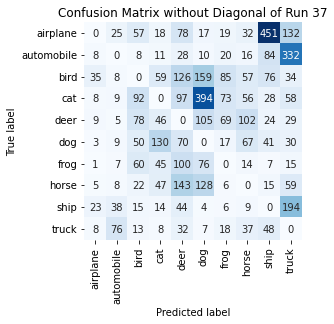

Summing down the rows, for Predictions of each Class that were wrong:  [100. 185. 395. 378. 718. 900. 313. 390. 774. 883.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  143.0 times
Summing across the columns, for total number of that True Class misidentified:  [829. 517. 639. 815. 467. 417. 325. 433. 347. 247.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  105.0 times

 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 

   Begin Run:  38 on Dataset TrainA_Zipped

 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
Zo

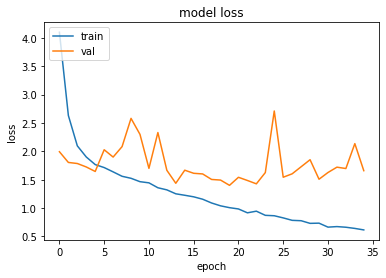

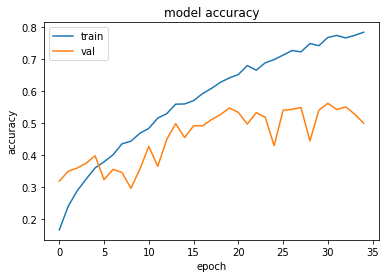

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  19 when  Val Loss was:  1.40018892288208 , and Val Acc happened to be 0.5461999773979187
Additionally, the best val acc epoch happened to be  30 when val acc was:  0.560699999332428 and Val Loss happened to be  1.6261231899261475
TestLoss:  1.3849958181381226  TestAcc: 0.5509999990463257
automobile 0.755
frog 0.731
horse 0.729
truck 0.712
dog 0.693
ship 0.664
airplane 0.408
deer 0.391
bird 0.293
cat 0.134


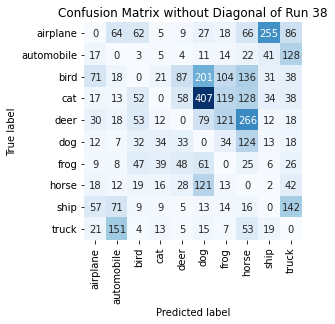

Summing down the rows, for Predictions of each Class that were wrong:  [252. 362. 281. 154. 277. 935. 444. 836. 413. 536.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  87.0 times
Summing across the columns, for total number of that True Class misidentified:  [592. 245. 707. 866. 609. 307. 269. 271. 336. 288.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  266.0 times

 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 

   Begin Run:  39 on Dataset TrainA_Zipped

 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
Z

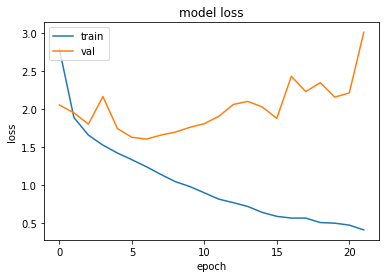

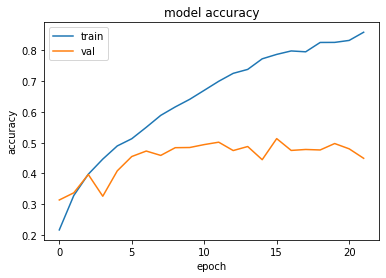

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  6 when  Val Loss was:  1.6066157817840576 , and Val Acc happened to be 0.47279998660087585
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.5131999850273132 and Val Loss happened to be  1.880206823348999
TestLoss:  1.6157066822052002  TestAcc: 0.46129998564720154
frog 0.764
dog 0.63
horse 0.62
truck 0.602
ship 0.508
automobile 0.428
deer 0.389
airplane 0.384
cat 0.163
bird 0.125


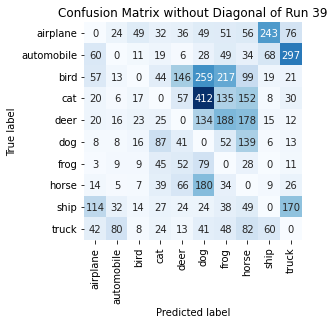

Summing down the rows, for Predictions of each Class that were wrong:  [ 338.  193.  154.  342.  441. 1206.  812.  817.  428.  656.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  146.0 times
Summing across the columns, for total number of that True Class misidentified:  [616. 572. 875. 837. 611. 370. 236. 380. 492. 398.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  188.0 times

 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 

   Begin Run:  40 on Dataset TrainA_Zipped

 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 

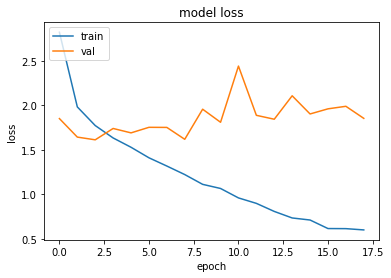

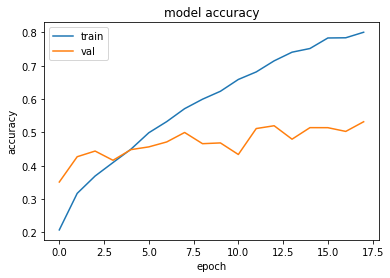

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  2 when  Val Loss was:  1.6125317811965942 , and Val Acc happened to be 0.4440999925136566
Additionally, the best val acc epoch happened to be  17 when val acc was:  0.5320000052452087 and Val Loss happened to be  1.8532036542892456
TestLoss:  1.5971815586090088  TestAcc: 0.4440000057220459
ship 0.748
frog 0.669
dog 0.638
truck 0.581
horse 0.555
automobile 0.422
deer 0.337
airplane 0.248
bird 0.206
cat 0.036


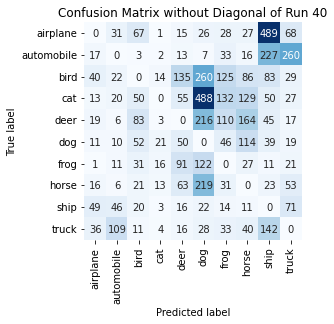

Summing down the rows, for Predictions of each Class that were wrong:  [ 202.  261.  338.   77.  454. 1388.  552.  614. 1109.  565.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  135.0 times
Summing across the columns, for total number of that True Class misidentified:  [752. 578. 794. 964. 663. 362. 331. 445. 252. 419.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  216.0 times

 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 

   Begin Run:  41 on Dataset TrainA_Zipped

 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 

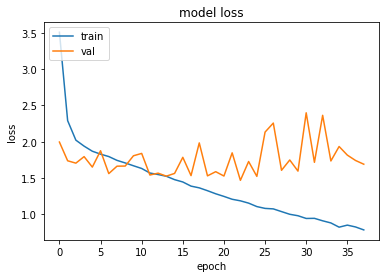

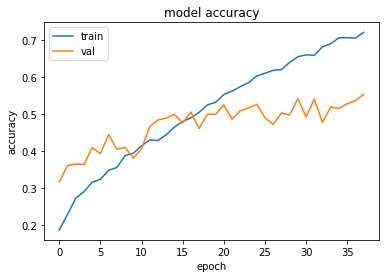

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  22 when  Val Loss was:  1.4674906730651855 , and Val Acc happened to be 0.5083000063896179
Additionally, the best val acc epoch happened to be  37 when val acc was:  0.5529000163078308 and Val Loss happened to be  1.689719319343567
TestLoss:  1.4378325939178467  TestAcc: 0.5105000138282776
truck 0.803
dog 0.667
horse 0.654
ship 0.583
deer 0.55
frog 0.477
automobile 0.443
bird 0.419
airplane 0.416
cat 0.093


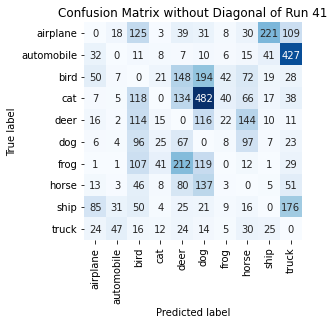

Summing down the rows, for Predictions of each Class that were wrong:  [ 234.  118.  683.  137.  736. 1124.  143.  482.  346.  892.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  212.0 times
Summing across the columns, for total number of that True Class misidentified:  [584. 557. 581. 907. 450. 333. 523. 346. 417. 197.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  144.0 times

 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 

   Begin Run:  42 on Dataset TrainA_Zipped

 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:

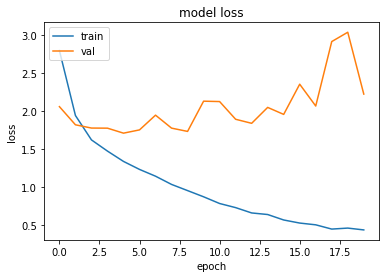

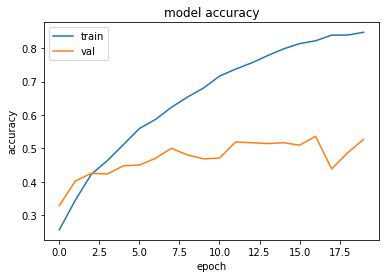

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.710497498512268 , and Val Acc happened to be 0.44780001044273376
Additionally, the best val acc epoch happened to be  16 when val acc was:  0.5361999869346619 and Val Loss happened to be  2.06738018989563
TestLoss:  1.6853235960006714  TestAcc: 0.45019999146461487
frog 0.791
truck 0.696
horse 0.621
deer 0.582
ship 0.575
automobile 0.385
dog 0.378
airplane 0.272
cat 0.114
bird 0.088


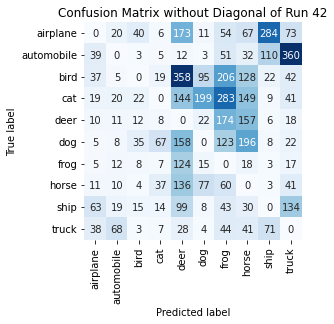

Summing down the rows, for Predictions of each Class that were wrong:  [ 227.  173.  142.  170. 1232.  434. 1038.  818.  516.  748.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  358.0 times
Summing across the columns, for total number of that True Class misidentified:  [728. 615. 912. 886. 418. 622. 209. 379. 425. 304.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  174.0 times

 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 

   Begin Run:  43 on Dataset TrainA_Zipped

 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut: 

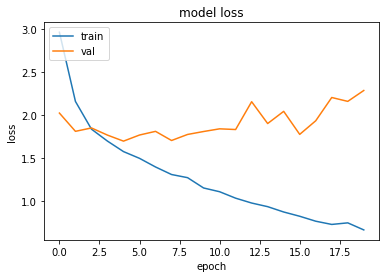

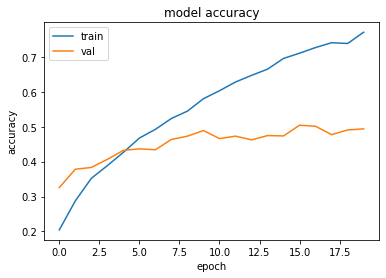

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.6989572048187256 , and Val Acc happened to be 0.43230000138282776
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.5044000148773193 and Val Loss happened to be  1.7776145935058594
TestLoss:  1.677824854850769  TestAcc: 0.42899999022483826
dog 0.748
horse 0.632
ship 0.58
frog 0.558
truck 0.51
automobile 0.397
airplane 0.317
deer 0.308
bird 0.183
cat 0.057


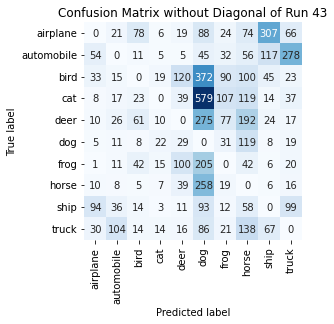

Summing down the rows, for Predictions of each Class that were wrong:  [ 245.  249.  256.  101.  378. 2001.  413.  898.  594.  575.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  120.0 times
Summing across the columns, for total number of that True Class misidentified:  [683. 603. 817. 943. 692. 252. 442. 368. 420. 490.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  275.0 times

 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 

   Begin Run:  44 on Dataset TrainA_Zipped

 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.16 

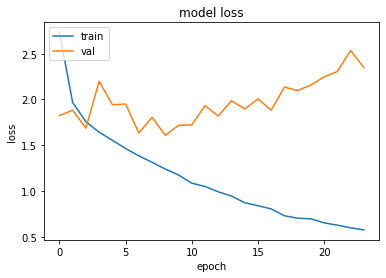

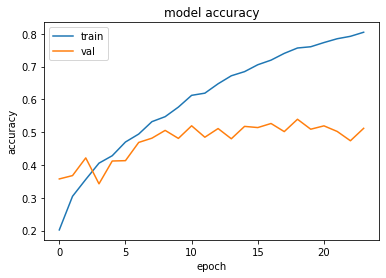

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  8 when  Val Loss was:  1.609356164932251 , and Val Acc happened to be 0.5054000020027161
Additionally, the best val acc epoch happened to be  18 when val acc was:  0.5393000245094299 and Val Loss happened to be  2.098301649093628
TestLoss:  1.5864619016647339  TestAcc: 0.5081999897956848
truck 0.645
horse 0.643
dog 0.633
frog 0.62
ship 0.605
airplane 0.533
automobile 0.491
deer 0.401
bird 0.305
cat 0.206


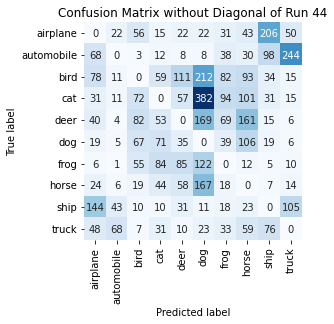

Summing down the rows, for Predictions of each Class that were wrong:  [ 458.  171.  371.  379.  417. 1116.  422.  628.  491.  465.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  111.0 times
Summing across the columns, for total number of that True Class misidentified:  [467. 509. 695. 794. 599. 367. 380. 357. 395. 355.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  169.0 times

 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 

   Begin Run:  45 on Dataset TrainA_Zipped

 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )


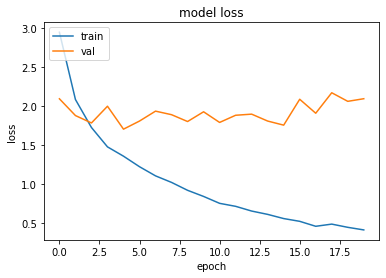

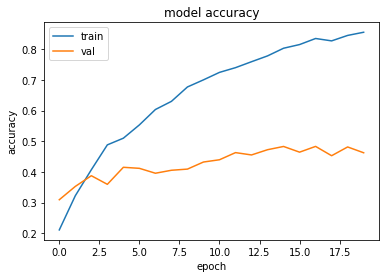

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  4 when  Val Loss was:  1.7049731016159058 , and Val Acc happened to be 0.41499999165534973
Additionally, the best val acc epoch happened to be  16 when val acc was:  0.4832000136375427 and Val Loss happened to be  1.9086675643920898
TestLoss:  1.6945711374282837  TestAcc: 0.4207000136375427
frog 0.873
ship 0.646
horse 0.636
truck 0.593
dog 0.417
automobile 0.367
bird 0.283
airplane 0.201
deer 0.122
cat 0.069


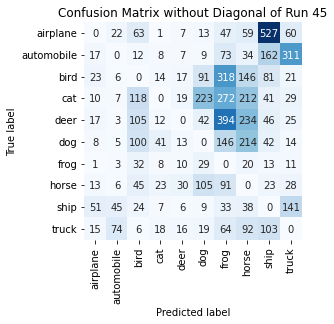

Summing down the rows, for Predictions of each Class that were wrong:  [ 155.  171.  505.  132.  125.  540. 1438. 1049. 1038.  640.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  30.0 times
Summing across the columns, for total number of that True Class misidentified:  [799. 633. 717. 931. 878. 583. 127. 364. 354. 407.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  394.0 times

 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 

   Begin Run:  46 on Dataset TrainA_Zipped

 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 

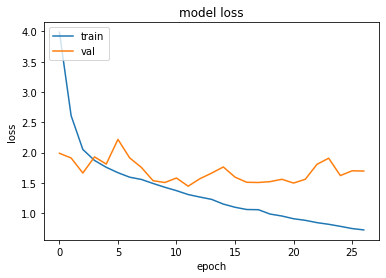

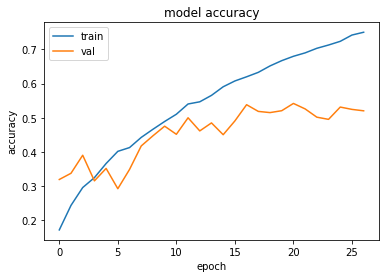

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  11 when  Val Loss was:  1.4444457292556763 , and Val Acc happened to be 0.5
Additionally, the best val acc epoch happened to be  20 when val acc was:  0.5419999957084656 and Val Loss happened to be  1.4961824417114258
TestLoss:  1.429924726486206  TestAcc: 0.49000000953674316
dog 0.774
frog 0.735
ship 0.662
automobile 0.658
horse 0.56
truck 0.545
airplane 0.311
deer 0.301
bird 0.274
cat 0.08


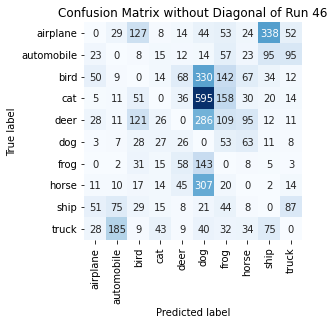

Summing down the rows, for Predictions of each Class that were wrong:  [ 199.  339.  421.  177.  276. 1780.  668.  352.  592.  296.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  68.0 times
Summing across the columns, for total number of that True Class misidentified:  [689. 342. 726. 920. 699. 226. 265. 440. 338. 455.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  286.0 times

 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 

   Begin Run:  47 on Dataset TrainA_Zipped

 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 120 , 120 )
ZoomOut

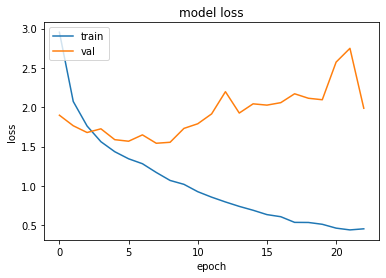

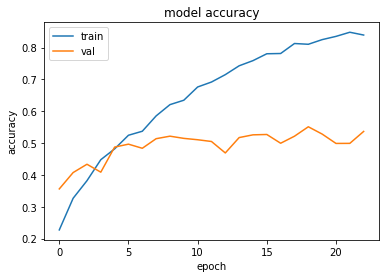

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  7 when  Val Loss was:  1.5427685976028442 , and Val Acc happened to be 0.5139999985694885
Additionally, the best val acc epoch happened to be  18 when val acc was:  0.5514000058174133 and Val Loss happened to be  2.114729404449463
TestLoss:  1.521652102470398  TestAcc: 0.522599995136261
truck 0.77
ship 0.735
frog 0.726
horse 0.708
deer 0.57
automobile 0.493
dog 0.471
airplane 0.326
bird 0.238
cat 0.189


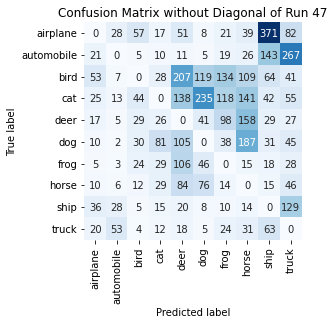

Summing down the rows, for Predictions of each Class that were wrong:  [197. 145. 210. 247. 740. 543. 476. 720. 776. 720.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  207.0 times
Summing across the columns, for total number of that True Class misidentified:  [674. 507. 762. 811. 430. 529. 274. 292. 265. 230.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  158.0 times

 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 

   Begin Run:  48 on Dataset TrainA_Zipped

 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.0 , -0.0 )


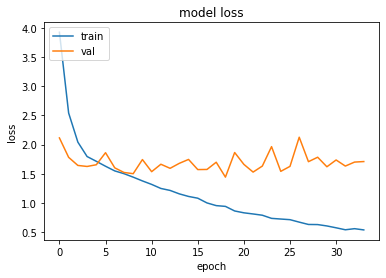

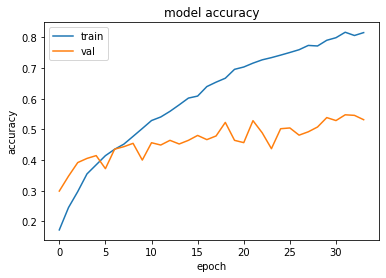

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  18 when  Val Loss was:  1.4424149990081787 , and Val Acc happened to be 0.5227000117301941
Additionally, the best val acc epoch happened to be  31 when val acc was:  0.5475000143051147 and Val Loss happened to be  1.6320518255233765
TestLoss:  1.4395684003829956  TestAcc: 0.5212000012397766
frog 0.841
truck 0.794
ship 0.665
horse 0.616
automobile 0.5
dog 0.479
deer 0.449
airplane 0.328
bird 0.296
cat 0.244


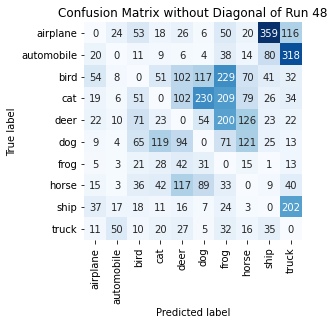

Summing down the rows, for Predictions of each Class that were wrong:  [192. 125. 336. 321. 532. 543. 886. 464. 599. 790.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  117.0 times
Summing across the columns, for total number of that True Class misidentified:  [672. 500. 704. 756. 551. 521. 159. 384. 335. 206.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  200.0 times

 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 

   Begin Run:  49 on Dataset TrainA_Zipped

 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
Z

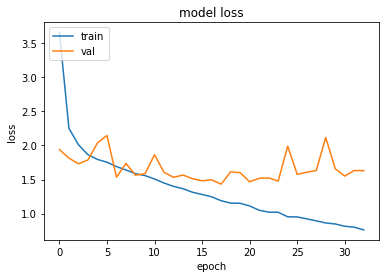

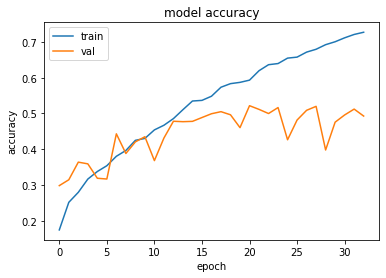

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  17 when  Val Loss was:  1.4318816661834717 , and Val Acc happened to be 0.5049999952316284
Additionally, the best val acc epoch happened to be  20 when val acc was:  0.5217000246047974 and Val Loss happened to be  1.4678218364715576
TestLoss:  1.399166464805603  TestAcc: 0.5052000284194946
truck 0.73
frog 0.71
dog 0.684
horse 0.611
ship 0.579
deer 0.489
airplane 0.402
automobile 0.396
bird 0.255
cat 0.196


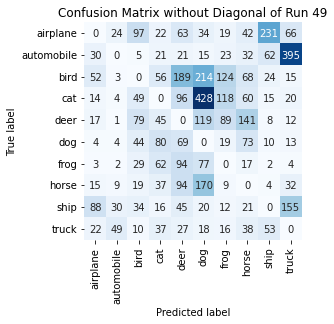

Summing down the rows, for Predictions of each Class that were wrong:  [ 245.  126.  366.  376.  698. 1095.  429.  492.  409.  712.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  189.0 times
Summing across the columns, for total number of that True Class misidentified:  [598. 604. 745. 804. 511. 316. 290. 389. 421. 270.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  141.0 times

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 

   Begin Run:  50 on Dataset TrainA_Zipped

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( 

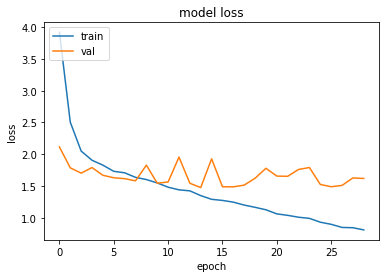

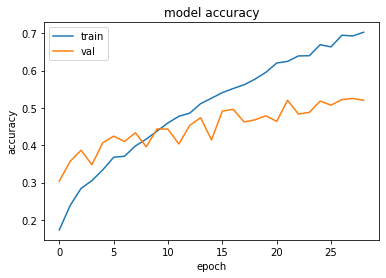

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  13 when  Val Loss was:  1.4770656824111938 , and Val Acc happened to be 0.47369998693466187
Additionally, the best val acc epoch happened to be  27 when val acc was:  0.5250999927520752 and Val Loss happened to be  1.6288036108016968
TestLoss:  1.4709573984146118  TestAcc: 0.4745999872684479
ship 0.735
frog 0.693
dog 0.684
truck 0.653
horse 0.467
deer 0.448
bird 0.413
automobile 0.407
airplane 0.201
cat 0.045


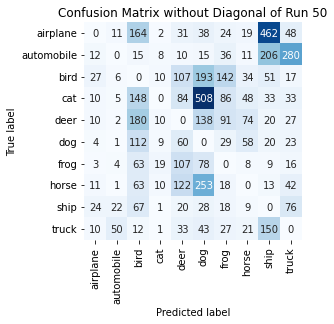

Summing down the rows, for Predictions of each Class that were wrong:  [ 111.  102.  824.   70.  574. 1294.  471.  282.  964.  562.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  122.0 times
Summing across the columns, for total number of that True Class misidentified:  [799. 593. 587. 955. 552. 316. 307. 533. 265. 347.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  180.0 times


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AttributeError: ignored

In [67]:
run_through_runs(ds=trainA, ds_noalb=trainA_noalb, dstitle = "TrainA_Zipped", showpictures=False, troubleshooting=False)

In [ ]:
run_through_runs(ds=trainB, ds_noalb=trainB_noalb, dstitle = "TrainB_Zipped", showpictures=False)

In [ ]:
run_through_runs(ds=trainC, ds_noalb=trainC_noalb, dstitle = "TrainC_Zipped", showpictures=False)

In [ ]:
run_through_runs(ds=trainD, ds_noalb=trainD_noalb, dstitle = "TrainD_Zipped", showpictures=False)

In [ ]:
run_through_runs(ds=trainE, ds_noalb=trainE_noalb, dstitle = "TrainE_Zipped", showpictures=False)

In [ ]:
run_through_runs(ds=trainF, ds_noalb=trainF_noalb, dstitle = "TrainF_Zipped", showpictures=False)

In [ ]:
run_through_runs(ds=trainG, ds_noalb=trainG_noalb, dstitle = "TrainG_Zipped", showpictures=False)

In [ ]:
run_through_runs(ds=trainH, ds_noalb=trainH_noalb, dstitle = "TrainH_Zipped", showpictures=False)

## 4.2:  Groups of two: AB, CD, EF, GH, 

Merged Groups of 2 
1. Group1_A_B
2. Group2_C_D
3. Group3_E_F
4. Group4_G_H

then later.. 

Merged Groups of 4
1. Group1_a_b_c_d
2. Group2_e_f_g_h

and finally

1. Group_all



In [ ]:
# trainA_noalb + trainB_noalb
# combine datasets I believe I need to add trainA_noalb, and trainB_noalb or just trainA+trainB and then send through no_augmentations...

# pretty_display_of_dataset(trainAB, "AB", opttext="trainAB pictures") # works


# ~~~~~~~~~~ No Augment Versions: ~~~~~~~~~~~~~~~~~~~~~~
trainAB_noalb = make_noalb(trainAB, "AB")           # just testing AB now

 
# Uncomment when ready to run
trainCD_noalb = make_noalb(trainCD, "CD")
trainEF_noalb = make_noalb(trainEF, "EF")
trainGH_noalb = make_noalb(trainGH, "GH")

# # ---  Larger Groups of Four Single Groups ---
 

# # ~~~~~~~~~~ No Augment Versions: ~~~~~~~~~~~~~~~~~~~~~~
trainABCD_noalb = make_noalb(trainABCD, "ABCD")
trainEFGH_noalb = make_noalb(trainEFGH, "EFGH")

# # --- Largest Groups of Eight single Groups ---
trainALL = trainABCD.concatenate(trainEFGH, "ABCDEFGH")
trainALL_noalb = make_noalb(trainALL, "ABCDEFGH")
# groupnum=2
# new_trainX_batch = 10*groupnum  # to ensure you get all 10 categories  
# tot_new_trainX =   5000*groupnum # should be 250*10*2 = 5000  #for FIRST groups but not COMBINED GROUP RUNS = 10000
    

# pretty_display_of_dataset(trainAB_noalb, "AB_noalb") #works
# trainAB_alb = augment_data(dataset = trainAB, process= process_data, dataset_text = "Augmented Dataset", )
# new_trainAB = zip_2_sets(tuple_of_2_subsets_to_zip=(trainAB_noalb, trainAB_alb), opttext="NoAlb+Alb")
# new_trainAB_batched_shuffle = minibatch_shuffle_unbatch_cache_prefetch_bigbatch(new_trainAB, batch=new_trainX_batch, groupnum=2, SEED = 42)
# print(new_trainAB_batched_shuffle)  #prints 500.. batches of 10?
# count_images(new_trainAB_batched_shuffle)
# run_through_runs(ds=trainAB, ds_noalb=trainAB_noalb, dstitle = "TrainAB", groupnum = 2, showpictures=True, troubleshooting=True) #stops at batch2
# view_40_images(new_trainAB_batched_shuffle)
# view_40_images(make_unbatched(new_trainAB_batched_shuffle))  ##WORKS
# pretty_display_of_dataset(ds = make_unbatched(new_trainAB_batched_shuffle), dstitle="trainAB", opttext= str(("newTrainX batched and shuffled using groupnum=") + str(groupnum)), troubleshooting=True) 



In [ ]:
# hasattr(trainAB, '_input_dataset')

# hasattr(trainA, '_input_dataset._input_dataset') 

AB, CD

In [ ]:
trainX_list = (trainAB, trainCD)
trainXnoalb_list  = (trainAB_noalb, trainCD_noalb)
trainXtitle_list = ("AB", "CD")
showpictures_list= (False, False)

for trainX, trainX_noalb, trainXtitle, pictures in zip(trainX_list, trainXnoalb_list, trainXtitle_list, showpictures_list):
  run_through_runs(ds=trainX, ds_noalb=trainX_noalb, dstitle = trainXtitle, groupnum=2, showpictures=pictures, troubleshooting=False)

filename will be:  runs_GroupAB .pkl

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

   Begin Run:  0 on Dataset AB

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 0 , 0 )
blur:     ( 0 , 1 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   ( 0.0 , 0.0 )
Darken:   ( -0.0 , -0.0 )
Rotate:   ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:    0
pVerticalFlip:      0
pEqualize:          0
pFancyPCA:          0
pChannelShuffle:    0
pElasticTransform:  0
pToGray:            0
 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 


NoAlb+Alb
new_trainX created from noalb and alb zipped together
new_trainX type is,  <FlatMapDataset shapes: ((32, 32, 3), ())

EF, GH

In [ ]:
trainX_list = (trainEF, trainGH)
trainXnoalb_list  = (trainEF_noalb, trainGH_noalb)
trainXtitle_list = ("EF", "GH")
showpictures_list= (False, False)

for trainX, trainX_noalb, trainXtitle, pictures in zip(trainX_list, trainXnoalb_list, trainXtitle_list, showpictures_list):
  run_through_runs(ds=trainX, ds_noalb=trainX_noalb, dstitle = trainXtitle,  groupnum=2, showpictures=pictures, troubleshooting=False)

ABCD, EFGH

In [ ]:
trainX_list = (trainABCD, trainEFGH)
trainXnoalb_list  = (trainABCD_noalb, trainEFGH_noalb)
trainXtitle_list = ("ABCD", "EFGH")
showpictures_list= (False, False)

for trainX, trainX_noalb, trainXtitle, pictures in zip(trainX_list, trainXnoalb_list, trainXtitle_list, showpictures_list):
  run_through_runs(ds=trainX, ds_noalb=trainX_noalb, dstitle = trainXtitle,  groupnum=4, showpictures=pictures, troubleshooting=False)

trainABCDEFGH

In [ ]:
run_through_runs(ds=trainABCDEFGH, ds_noalb=trainABCDEFGH_noalb, dstitle = "trainABCDEFGH",  groupnum=8, showpictures=False, troubleshooting=False)

So far in my effort to concatenate groupA and groupB and run it through the model, it's taken at least 20 minutes to just count the number of images in each class, display the images, and another 5 minutes to run Run0 through the CNN.   At ~25 minutes per run it would take about ~1275 minutes per Group.  There are 7 more groups, that's 8925 minutes, or 148 hours.  Obviously I cant display images for each run or that would take forever.  At 33 minutes I'm not even done running Run 1.

Looking for a faster way to count the dataset, SO, user says \\
`ds.map(lambda x: 1, num_parallel_calls=tf.data.experimental.AUTOTUNE).reduce(tf.constant(0), lambda x,_: x+1) `

In [ ]:
# ds.map(lambda x: 1, num_parallel_calls=AUTOTUNE).reduce(tf.constant(0), lambda x: 1)

## Time Required: 10 hours



In [ ]:
stop_testing = time.time()
print((stop_testing - tic) , "secs to  run everything start to end, or... ")
print((stop_testing - tic)/60, "minutes ... or ")
print((stop_testing - tic)/3600, "hours ")



---



# 5. Post-Test: Process Results

After the 51 runs for the single groups have been run, its time to load the results into JMP to Fit the Definitive Screening Design and find which Main Effects have the most compeling effect.   

* I need to get my pickle files unloaded into a dataframe to put in a CSV.

* I had unintentionally created an effect that was captured by my blocking variable (early October?), but have since fixed it.  Original results here -- "[GroupA_Test1](https://github.com/RachelRamirez/CIFAR-10/blob/main/CollectionofTests/Test1GroupA.ipynb)" 



---



as of 11/11/21 its  ** ~9 hours** to run   9 Groups with 51 Runs, at about 45 epochs each.  If I ran it again with GroupA (10th GRoup) it would probably be about 10.5 hours total to this point.  Also note that is just training and capturing results, not diplaying any images thru augmentations, as displaying images and counting the number in each batch is extremely time consuming.  I think it makes one experimental run take at least 20 minutes, so  20times longer overall.



---



In [ ]:
import pickle
import numpy as np
import csv
# what does a flattened confuion matrix look like 


#define a list of the pickle files
list_of_pickle_file_names = ['runs_GroupB_final.pkl', 
                             'runs_GroupC_final.pkl', 
                             'runs_GroupD_final.pkl', 
                             'runs_GroupE_final.pkl', 
                             'runs_GroupF_final.pkl', 
                             'runs_GroupG_final.pkl', 
                             'runs_GroupH_final.pkl',] 
                            #  'runs_GroupI_final.pkl', 
                            #  'runs_GroupJ_final.pkl']

list_of_group_names = ("B", "C", "D", "E", "F", "G", "H")    #, "I", "J")

 
 
ds = {}

#for enumerate () zip the 9 pickle files:
for Z, pkl, in zip(list_of_group_names, list_of_pickle_file_names): #list_of_unpickled_names):
  
  with open(pkl, 'rb') as fid:
     print("dataset", Z, " loaded from", pkl)
     ds[Z] = pickle.load(fid)
 

#To reference a Group say ds["Letter"][RunInt]["Metric"]
# The problem was i didnt have a I or J file with runs, nor some runs with 0
# ds["B"][23]["CM_norm"]
# ds["C"][23]["CM_norm"]

ds['B'][0]["CM"]  # the first array of ds["B"][1]["CM"] is [551,  29,  37,  23,  45,  23,  37,  18, 199,  38],
ds['B'][1]["CM"]  # the first array of ds["B"][1]["CM"] is [602,  54,  54,  19,  18,  17,  23,  19, 148,  46],

#can i just replace it Group , and each run, with this function? It'd be ice if i could map it.. versus a for loop of doomr
rows = []
for i in (list_of_group_names):
  for run in range(1,51):             #<!!---------------- ------ change back to 0 once you have and/or end with 51
    cm = (ds[i][run]["CM"]).flatten(order="C")
    cm = cm.flatten()
    cm_norm = (ds[i][run]["CM_norm"]).flatten(order="C")
    cm_norm = cm_norm.flatten()
    # print("new", cm_flat_new)
    row = [i, run,  ds[i][run]["TestAccuracy"],  ds[i][run]["TestLoss"], cm, cm_norm]
    rows.append(row)


df_Groups = pd.DataFrame(rows, columns=["Group", "Run", "TestAccuracy", "TestLoss", "CM", "CM_norm"])

df = df_Groups

CM_arr = np.array(df.loc[:,"CM"].to_list()) # this takes all rows in column "CM"
CM_df = pd.DataFrame(CM_arr) #350 rows 100 columns
CM_df = CM_df.reset_index(drop=True)
new_df = pd.concat([df_Groups, CM_df ], axis=1)

CM_norm_arr = np.array(df.loc[:,"CM_norm"].to_list()) # this takes all rows in column "CM"
CM_norm_df = pd.DataFrame(CM_norm_arr) #350 rows 100 columns
CM_norm_df = CM_norm_df.reset_index(drop=True)

# Place the DataFrames side by side
# horizontal_stack = pd.concat([survey_sub, survey_sub_last10], axis=1)

new_df = pd.concat([new_df, CM_norm_df ], axis=1)
new_df.to_csv('test.csv')




 
 